#### <font color='purple'> [Elliptical Galaxies Defn](#1)
#### <font color='purple'> [Disk Galaxies Defn](#2)
#### <font color='darkviolet'> [Physical Formula Manually](#3)
#### <font color='purple'>[1. Disk Galaxies](#4)
#### <font color='darkorange'>[1.b. Small vdiks: Vdisk<=1.0 cases](#5)
#### <font color='darkorange'>[1.c. Big vdiks: Vdisk>1.0 cases](#6)                                              ####<font color='darkgreen'>[1.d. Big vdisks in 3 different bins](#7)  
##### <font color='darkgreen'>[1.d.1. Population 1: 1.0<=Vdisk<1.15](#8)
     
[Elliptical Galaxies](#10)




### This code provides analysis on the procedure to extract the physical model of galaxy sizes manually, using the most important features as identified in notebook TNG-SAM_z=0_v13. 
#### The approach is to first look at the best different physical models per galaxy morphology: Disk, Bulgy Disks, Bulgier Disks and Ellipticals.
#### The model derived for Disks in this notebook DOES take into account small size galaxies (spin ~0.2; the vertical part of the hockey stick in the spin-size plot). The models derived for Disks are then applied on Bulgy Disks to see their performance.




In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here


#### Read the normalized 31-feature dataset (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [2]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

#### Add the column 'BulgeMstar_ratio' defined as Bulge mass / Stellar mass, to be used as a proxy for galaxy morphology

In [3]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']


In [4]:
df_normalized_31.shape

(35390, 33)

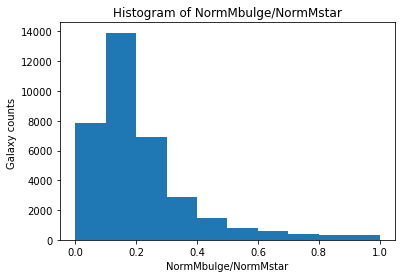

In [5]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Histogram of NormMbulge/NormMstar')
plt.xlabel('NormMbulge/NormMstar')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropNormMbulgebyNormMstar.jpg', dpi=500)

plt.show()

## <font color='purple'> <a id =2> </a> <br>Disk Galaxies Defn

In [6]:
df_disks = pd.read_csv('Disks Dataset_as defined in notebook v13')

In [7]:
df_disks.shape

(15717, 33)

In [8]:
X_disks = df_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_disks = df_disks.loc[:,'GalpropNormHalfRadius']

--------------------

## <font color='darkviolet'> <a id =3> </a> <br>Physical Formula Manually Derived

## <font color='purple'> <a id =4> </a> <br> 1. Disk Galaxies

Randomly sample df_disks to extract 10,000 galaxies out of total ~15,000 beause SR works with at most 10,000 entries


In [9]:
# choose the 7 most important features from analysis above to be used for physical modelling

X_disks_imp = df_disks.loc[:, ['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormMHI', 'HalopropC_nfw', 'GalpropNormMbulge',
                              'GalpropNormMH2', 'GalpropNormMstar' ]]


y_disks_imp = df_disks.loc[:, 'GalpropNormHalfRadius']

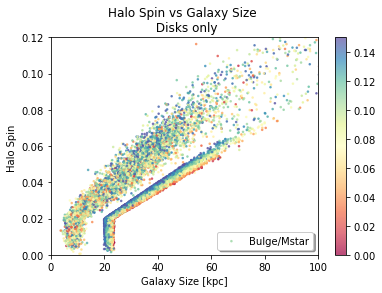

In [10]:
plt.scatter(y_disks_imp, X_disks_imp.loc[:, 'HalopropSpin'],
            c = df_disks['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'Bulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Disks only')
plt.xlabel('Galaxy Size [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000.jpeg', dpi=500)
plt.show()

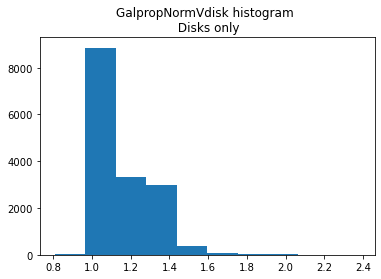

In [11]:
plt.hist(df_disks['GalpropNormVdisk'])
plt.title('GalpropNormVdisk histogram \n Disks only')
# plt.savefig('GalpropNormVdisk_disksonly_histogram', dpi=500)
plt.show()

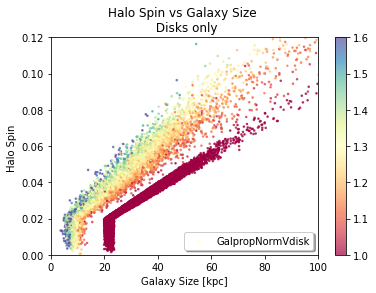

In [12]:
plt.scatter(y_disks_imp, X_disks_imp.loc[:, 'HalopropSpin'],
            c = df_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Disks only')
plt.xlabel('Galaxy Size [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000_vdisksmallerscale.jpeg', dpi=500)
plt.show()

In [13]:
df_disks_small = df_disks[df_disks['HalopropSpin']<=0.021] # 3,690 small disks according to this def

In [14]:
df_disks_small['GalpropNormVdisk'].values

array([1.21111868, 0.99308478, 0.9930831 , ..., 0.99308395, 0.99308433,
       0.99308392])

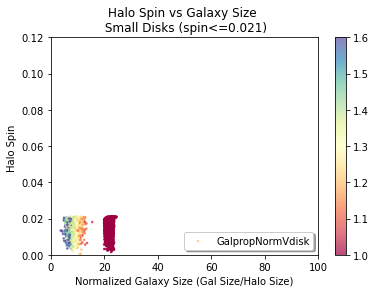

In [15]:
plt.scatter(df_disks_small.loc[:, 'GalpropNormHalfRadius'], df_disks_small.loc[:, 'HalopropSpin'],
            c = df_disks_small['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Small Disks (spin<=0.021)')
plt.xlabel('Normalized Galaxy Size (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Disks_Spin_vs_size_small_disks.jpeg', dpi=500)
plt.show()

### 1.a. Do NOT remove all disk sizes <24

In [16]:
df_disks.shape

(15717, 33)

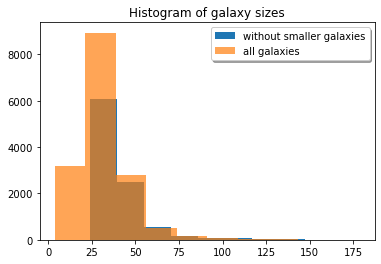

In [17]:
df_disks_wosmallgalaxies = df_disks.loc[df_disks.GalpropNormHalfRadius > 24]

plt.hist (df_disks_wosmallgalaxies['GalpropNormHalfRadius'], label = 'without smaller galaxies')
plt.hist (df_disks['GalpropNormHalfRadius'], alpha=0.7, label = 'all galaxies')
plt.title ('Histogram of galaxy sizes')
plt.legend (loc='upper right' , shadow=True)
plt.show()

### <font color='orange'> <a id =15> </a> <br>  1.e. Physical formula for Disks

In [18]:
from scipy.optimize import curve_fit

### case0: size_0 = a + b*spin + c*vdisk + d*spin*vdisk function

In [19]:
def spin_vdisk_func(spin_vdisk, a, b, c, d):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0] + c * spin_vdisk[1]  + d * spin_vdisk[0] * spin_vdisk[1]

In [20]:
HalopropSpin = np.array(df_disks['HalopropSpin'])

In [21]:
GalpropNormVdisk = np.array(df_disks['GalpropNormVdisk'])

In [22]:
Size = np.array(df_disks['GalpropNormHalfRadius'])

In [23]:
spin_vdisk = [HalopropSpin, GalpropNormVdisk]

In [24]:
spin_vdisk = np.array (spin_vdisk) # convert list into array

In [25]:
popt, pcov = curve_fit(spin_vdisk_func, spin_vdisk, Size)

In [26]:
popt

array([  26.81021506, 1647.01253084,  -20.05595563, -784.54571464])

In [27]:
size_0 = spin_vdisk_func(spin_vdisk, *popt)

In [28]:
size_0.shape

(15717,)

In [29]:
Size.shape

(15717,)

In [30]:
# r2_score(y_true, y_pred)
r2_score_size_funcsize_0=r2_score(Size, size_0)

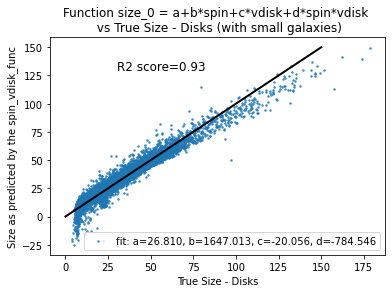

In [31]:
plt.scatter(Size, size_0, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_0), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.title('Function size_0 = a+b*spin+c*vdisk+d*spin*vdisk \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the spin_vdisk_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_0_wsmallgals.jpeg', dpi=500)
plt.show()

### case 1: size_1 = a + b*spin + d*spin*vdisk function

In [32]:
def spin_vdisk_func_1(spin_vdisk, a, b, d):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0]  + d * spin_vdisk[0] * spin_vdisk[1]

In [33]:
popt_1, pcov_1 = curve_fit(spin_vdisk_func_1, spin_vdisk, Size)

In [34]:
size_1 = spin_vdisk_func_1(spin_vdisk, *popt_1)

In [35]:
r2_score_size_funcsize_1=r2_score(Size, size_1)

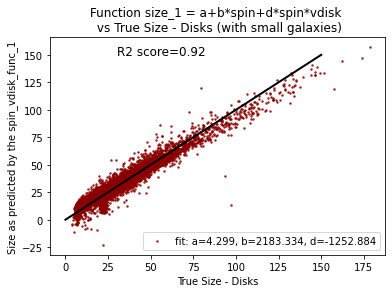

In [36]:
plt.scatter(Size, size_1, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f' % tuple(popt_1))
plt.text(30, 150, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_1), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_1 = a+b*spin+d*spin*vdisk \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the spin_vdisk_func_1')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_1_wsmallgals.jpeg', dpi=500)
plt.show()

### case 2: size_2 = spin/vdisk function

In [37]:
def spin_over_vdisk_func(spin_vdisk, a, b):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0]*(1/ spin_vdisk[1])

In [38]:
popt_2, pcov_2 = curve_fit(spin_over_vdisk_func, spin_vdisk, Size)

In [39]:
size_2 = spin_over_vdisk_func(spin_vdisk, *popt_2)

In [40]:
r2_score_size_funcsize_2=r2_score(Size, size_2)

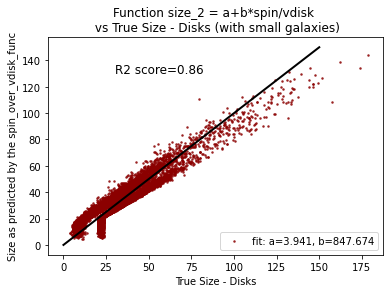

In [41]:
plt.scatter(Size, size_2, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_2))
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_2), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_2 = a+b*spin/vdisk \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the spin_over_vdisk_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_2_wsmallgals.jpeg', dpi=500)
plt.show()

### case 3: size_3 = spin/vdisk^2 function (the function predicted by SR)

In [42]:
def spin_over_vdisk_squared_func(spin_vdisk, a, b):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0]*(1/ (spin_vdisk[1])**2)

In [43]:
popt_3, pcov_3 = curve_fit(spin_over_vdisk_squared_func, spin_vdisk, Size)

In [44]:
size_3 = spin_over_vdisk_squared_func(spin_vdisk, *popt_3)

In [45]:
r2_score_size_funcsize_3=r2_score(Size, size_3)

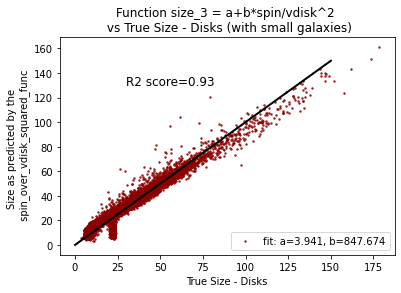

In [46]:
plt.scatter(Size, size_3, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_2))
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_3), size=12)
# plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_3 = a+b*spin/vdisk^2 \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_3_wsmallgals.jpeg', dpi=500)
plt.show()

### case 3a: size_3a = spin/vdisk^2 function exactly as predicted by SR

In [47]:
# The SR best eqution for Disks with n_iter=100 and n_iter=500, and new eqn grid including division
# 1054.8468*HalopropSpin/GalpropNormVdisk**2
size_3a = 1054.8468*HalopropSpin/(GalpropNormVdisk**2)

In [48]:
r2_score_size_funcsize_3a=r2_score(Size, size_3a)

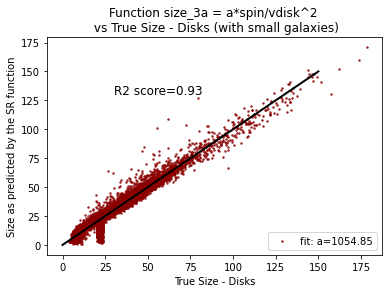

In [49]:
plt.scatter(Size, size_3a, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=1054.85')
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_3a), size=12)
# plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_3a = a*spin/vdisk^2 \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the SR function')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_3a_wsmallgals.jpeg', dpi=500)
plt.show()

### case 4: size_4 = a + b*spin + d*spin*vdisk + e*(Mbulge/Mstar)



In [50]:
def spin_vdisk_bulgemstar_func(spin_vdisk_bmstar, a, b, d, e):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk_bmstar[0]
    # vdisk is spin_vdisk_bmstar[1]
    # Mbulge/Mstar is spin_vdisk_bmstar[2]
    return a + b*spin_vdisk_bmstar[0]  + d * spin_vdisk_bmstar[0] * spin_vdisk_bmstar[1] + e*spin_vdisk_bmstar[2]

In [51]:
BulgeMstar = np.array (df_disks.loc[:, 'BulgeMstar_ratio'])

spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])

In [52]:
popt_4, pcov_4 = curve_fit(spin_vdisk_bulgemstar_func, spin_vdisk_bmstar, Size)

size_4 = spin_vdisk_bulgemstar_func(spin_vdisk_bmstar, *popt_4)

r2_score_size_funcsize_4=r2_score(Size, size_4)

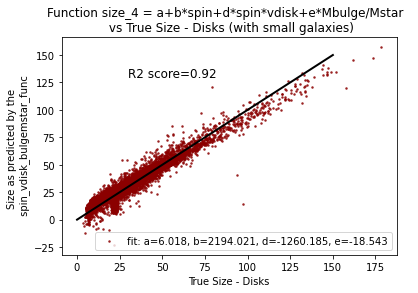

In [53]:
plt.scatter(Size, size_4, marker='.', s=10, alpha=0.7, c = 'darkred', 
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt_4))
# plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_4), size=12)
plt.title('Function size_4 = a+b*spin+d*spin*vdisk+e*Mbulge/Mstar  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_vdisk_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_4_wsmallgals.jpeg', dpi=500)
plt.show()

### case 5: size_5 = a + b*spin + d*spin*vdisk + f*ln(1-Mbulge/Mstar)

In [54]:
def spin_vdisk_log_bulgemstar_func(spin_vdisk_bmstar, a, b, d, f):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk_bmstar[0]
    # vdisk is spin_vdisk_bmstar[1]
    # Mbulge/Mstar is spin_vdisk_bmstar[2]
    # Note that the last term of the func makes use of the natural logarithm (base e), not log10
    return a + b*spin_vdisk_bmstar[0]  + d * spin_vdisk_bmstar[0] * spin_vdisk_bmstar[1] + f*np.log(1-spin_vdisk_bmstar[2])

In [55]:
popt_5, pcov_5 = curve_fit(spin_vdisk_log_bulgemstar_func, spin_vdisk_bmstar, Size)

In [56]:
size_5 = spin_vdisk_log_bulgemstar_func(spin_vdisk_bmstar, *popt_5)

In [57]:
r2_score_size_funcsize_5=r2_score(Size, size_5)

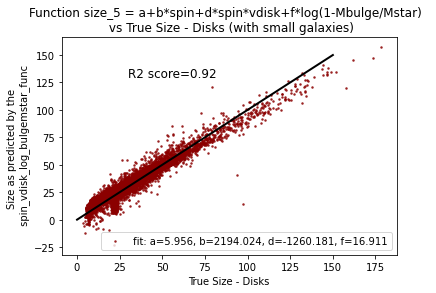

In [58]:
plt.scatter(Size, size_5, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, f=%5.3f' % tuple(popt_5))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_5), size=12)
plt.title('Function size_5 = a+b*spin+d*spin*vdisk+f*log(1-Mbulge/Mstar)  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_vdisk_log_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_5_wsmallgals.jpeg', dpi=500)
plt.show()

### case 6: size_6 = spin/vdisk^2 + Mbulge/Mstar function {(the function predicted by SR) + Mbulge/Mstar term}

In [59]:
def spin_over_vdisk_squared_bulgemstar_func(spin_vdisk_bmstar, a, b, g):
    # spin_vdisk_bmstar is a 3,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
     # Mbulge/Mstar is spin_vdisk_bmstar[2]
    return a + b*spin_vdisk_bmstar[0]*(1/ (spin_vdisk_bmstar[1])**2) + g*spin_vdisk_bmstar[2]

In [60]:
popt_6, pcov_6 = curve_fit(spin_over_vdisk_squared_bulgemstar_func, spin_vdisk_bmstar, Size)

In [61]:
size_6 = spin_over_vdisk_squared_bulgemstar_func(spin_vdisk_bmstar, *popt_6)

In [62]:
r2_score_size_funcsize_6=r2_score(Size, size_6)

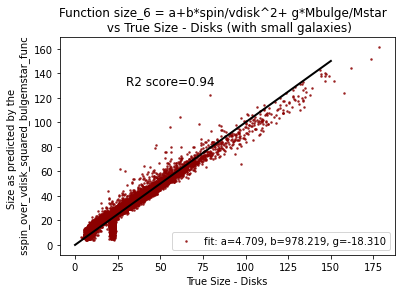

In [63]:
plt.scatter(Size, size_6, marker='.', s=10, alpha=0.7,c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, g=%5.3f' % tuple(popt_6))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_6), size=12)
plt.title('Function size_6 = a+b*spin/vdisk^2+ g*Mbulge/Mstar  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n sspin_over_vdisk_squared_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_6_wsmallgals.jpeg', dpi=500)
plt.show()

### case 7: size_7 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) function {(the function predicted by SR) + log(1-Mbulge/Mstar) term}

In [64]:
def spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar, a, b, h):
    # spin_vdisk_bmstar is a 3,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
     # Mbulge/Mstar is spin_vdisk_bmstar[2]
    return a + b*spin_vdisk_bmstar[0]*(1/ (spin_vdisk_bmstar[1])**2) + h*np.log(1-spin_vdisk_bmstar[2])

In [65]:
popt_7, pcov_7 = curve_fit(spin_over_vdisk_squared_log_bulgemstar_func, spin_vdisk_bmstar, Size)

In [66]:
size_7 = spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar, *popt_7)

In [67]:
r2_score_size_funcsize_7=r2_score(Size, size_7)

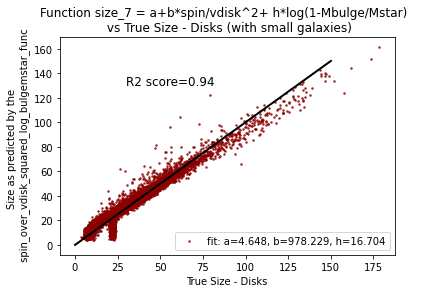

In [68]:
plt.scatter(Size, size_7, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f' % tuple(popt_7))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_7), size=12)
plt.title('Function size_7 = a+b*spin/vdisk^2+ h*log(1-Mbulge/Mstar)  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_7_wsmallgals.jpeg', dpi=500)
plt.show()

### case 8: size_8 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + j*MHI function

In [69]:
MHI = np.array (df_disks.loc[:, 'GalpropNormMHI'])

spin_vdisk_bmstar_MHI = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar, MHI])

In [70]:
def spin_over_vdisk_squared_log_bulgemstar_MHI_func(spin_vdisk_bmstar_MHI, a, b, h, j):
    # spin_vdisk_bmstar is a 4,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk_MHI[0]
    # vdisk is spin_vdisk_MHI[1]
    # Mbulge/Mstar is spin_vdisk_bmstar_MHI[2]
    # MHI is spin_vdisk_bmstar_MHI[3]    
    return a + b*spin_vdisk_bmstar_MHI[0]*(1/ (spin_vdisk_bmstar_MHI[1])**2) + h*np.log(1-spin_vdisk_bmstar_MHI[2]) + j*spin_vdisk_bmstar_MHI[3]

In [71]:
popt_8, pcov_8 = curve_fit(spin_over_vdisk_squared_log_bulgemstar_MHI_func, spin_vdisk_bmstar_MHI, Size)

size_8 = spin_over_vdisk_squared_log_bulgemstar_MHI_func(spin_vdisk_bmstar_MHI, *popt_8)

r2_score_size_funcsize_8=r2_score(Size, size_8)

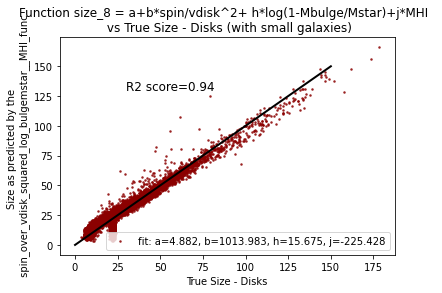

In [72]:
plt.scatter(Size, size_8, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_8))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_8), size=12)
plt.title('Function size_8 = a+b*spin/vdisk^2+ h*log(1-Mbulge/Mstar)+j*MHI  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar__MHI_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_8_wsmallgals.jpeg', dpi=500)
plt.show()

### case 9: size_9 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + spin*MHI function


In [73]:
def MHI_spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_MHI, a, b, h, j):
    # spin_vdisk_bmstar is a 4,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk_MHI[0]
    # vdisk is spin_vdisk_MHI[1]
    # Mbulge/Mstar is spin_vdisk_bmstar_MHI[2]
    # MHI is spin_vdisk_bmstar_MHI[3]    
    return a + b*spin_vdisk_bmstar_MHI[0]*(1/ (spin_vdisk_bmstar_MHI[1])**2) + h*np.log(1-spin_vdisk_bmstar_MHI[2]) + j*spin_vdisk_bmstar_MHI[0]*spin_vdisk_bmstar_MHI[3]

In [74]:
popt_9, pcov_9 = curve_fit(MHI_spin_over_vdisk_squared_log_bulgemstar_func, spin_vdisk_bmstar_MHI, Size)

size_9 = MHI_spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_MHI, *popt_9)

r2_score_size_funcsize_9=r2_score(Size, size_9)

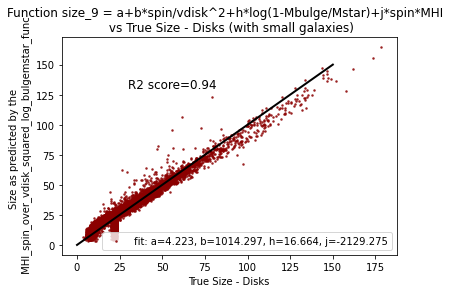

In [75]:
plt.scatter(Size, size_9, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_9))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_9), size=12)
plt.title('Function size_9 = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)+j*spin*MHI  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n MHI_spin_over_vdisk_squared_log_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_9_wsmallgals.jpeg', dpi=500)
plt.show()

## experimentation

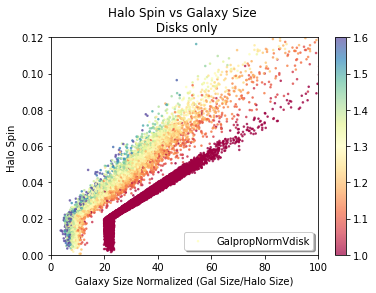

In [76]:
plt.scatter(df_disks.loc[:,'GalpropNormHalfRadius'], df_disks.loc[:, 'HalopropSpin'],
            c = df_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Disks only')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Disks_Spin_vs_Size_vdiskcolor.jpeg', dpi=500)
plt.show()

In [77]:
df_disks.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMaccdot_radio', 'GalpropMu_merger', 'GalpropOutflowRate_Mass',
       'GalpropOutflowRate_Metal', 'GalpropSfr', 'GalpropSfrave100myr',
       'GalpropSfrave1gyr', 'GalpropSfrave20myr', 'GalpropTmerger',
       'GalpropTmerger_major', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate',
       'HalopropMetal_ejected', 'HalopropSpin', 'HalopropZhot',
       'GalpropNormHalfRadius', 'GalpropNormMstar', 'HalopropNormMhot',
       'GalpropNormMbulge', 'GalpropNormMBH', 'GalpropNormMH2',
       'GalpropNormMHI', 'GalpropNormMHII', 'GalpropNormMcold',
       'GalpropNormMstar_merge', 'HalopropNormMass_ejected',
       'HalopropNormMstar_diffuse', 'GalpropNormSigmaBulge',
       'GalpropNormVdisk', 'BulgeMstar_ratio'],
      dtype='object')>

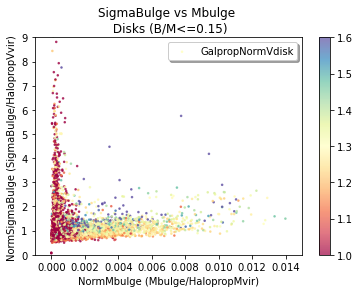

In [78]:
plt.scatter(df_disks.loc[:,'GalpropNormMbulge'], df_disks.loc[:, 'GalpropNormSigmaBulge'],
            c = df_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-0.001,0.015, 0.0,9])
plt.title('SigmaBulge vs Mbulge \n Disks (B/M<=0.15)')
plt.xlabel('NormMbulge (Mbulge/HalopropMvir)')
plt.ylabel('NormSigmaBulge (SigmaBulge/HalopropVvir) ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('Disks_SigmaBulge_vs_Mbulge_vdiskcolor.jpeg', dpi=500)
plt.show() 

In [79]:
gg = df_disks[df_disks.HalopropSpin<0.021]

In [80]:
kk = gg[(gg.GalpropNormHalfRadius>=18) & (gg.GalpropNormHalfRadius<30)]
kk.GalpropNormHalfRadius.min()

19.95969414876448

In [81]:
hh = gg[(gg.GalpropNormHalfRadius>=18) & (gg.GalpropNormVdisk.round(3)== 0.993)]

hh

,GalpropMaccdot_radio,GalpropMu_merger,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropTmerger,GalpropTmerger_major,...,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,HalopropNormMass_ejected,HalopropNormMstar_diffuse,GalpropNormSigmaBulge,GalpropNormVdisk,BulgeMstar_ratio
18,4.664630e-08,0.275067,1.424970,0.190941,0.031290,0.028684,0.030297,0.019181,11.71450,11.7145,...,0.000351,0.002377,0.001749,0.006058,0.000350,0.150078,0.000093,1.177592,0.993085,0.086053
20,5.237030e-08,0.228471,2.513150,0.325260,0.101569,0.094505,0.109319,0.062304,10.40290,12.0664,...,0.000600,0.003756,0.002204,0.008854,0.000086,0.145636,0.000022,0.759831,0.993083,0.047300
24,8.999430e-08,0.196946,3.375510,0.244704,0.074875,0.071929,0.032791,0.046020,11.78150,113.7020,...,0.000790,0.005769,0.003035,0.013117,0.000118,0.146673,0.000033,0.831421,0.993082,0.081181
32,1.529840e-08,0.118787,0.689800,0.029280,0.007428,0.006900,0.007174,0.004556,10.75260,113.7020,...,0.000173,0.002710,0.001999,0.006581,0.000037,0.163592,0.000013,0.746044,0.993084,0.076999
36,3.671560e-08,0.165254,1.066910,0.034571,0.013145,0.012423,0.019186,0.008070,5.80212,113.7020,...,0.000265,0.004457,0.002633,0.009895,0.000078,0.159721,0.000019,0.700262,0.993084,0.139494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15689,2.997010e-08,0.100444,1.817710,0.112157,0.031660,0.030289,0.030348,0.019456,12.57760,113.7020,...,0.000442,0.004172,0.002483,0.009523,0.000028,0.151498,0.000008,0.762165,0.993083,0.126781
15699,3.655430e-08,0.356318,0.554260,0.020106,0.006692,0.006541,0.014732,0.004115,11.38000,11.3800,...,0.000139,0.002629,0.001918,0.006271,0.000032,0.150003,0.000008,0.697546,0.993083,0.093367
15706,8.392080e-09,0.161094,1.428850,0.045097,0.014158,0.012446,0.005779,0.008722,12.35450,113.7020,...,0.000354,0.005662,0.003215,0.012343,0.000025,0.171226,0.000009,0.728764,0.993084,0.068962
15710,1.823330e-08,0.137306,0.632792,0.028979,0.006125,0.005694,0.005907,0.003757,12.60610,12.6994,...,0.000159,0.002405,0.001900,0.006027,0.000037,0.151492,0.000011,0.785135,0.993084,0.115467


In [82]:
df_disks_big = df_disks[df_disks['HalopropSpin']>0.021] 

### case 10: size_10 = spin/vdisk^2 + constant small galaxy sizes

In [83]:
def spin_vdisk2_wsmallgals_0_func(spin_vdisk, a, b):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    
    size = a + b*spin_vdisk[0]*(1/ (spin_vdisk[1])**2)
    
#     if np.any(size < size_min):
#         size[ size < size_min] = size_min
    
    # I want to define here a size value for spin=0.02 depending on vdisk values, but how?
    size_20_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)==0.993)
    size_20_inverse_filter = size_20_filter == False
    
    size_10_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)!=0.993)
    size_10_inverse_filter = size_10_filter == False


    
    # substitute size 20 in corresponding indices    
    size  = 20 * size_20_filter + size * size_20_inverse_filter
    # substitute size 10 in corresponding indices    
    size  = 10 * size_10_filter + size * size_10_inverse_filter

        
    return size

In [84]:
popt_10, pcov_10 = curve_fit(spin_vdisk2_wsmallgals_0_func, spin_vdisk, Size)

size_10 = spin_vdisk2_wsmallgals_0_func(spin_vdisk, *popt_10)

In [85]:
df_spin_size = df_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size["Predicted"] = size_10
zz = df_spin_size[df_spin_size['HalopropSpin']>0.021]
actual_size_10 = zz['GalpropNormHalfRadius']
predicted_size_10 = zz['Predicted']
r2_score(actual_size_10, predicted_size_10)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/4028646855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size["Predicted"] = size_10


0.96357288560615

In [86]:
(size_10 ==20).sum()

2778

In [87]:
r2_score_size_funcsize_10=r2_score(Size, size_10)
r2_score_size_funcsize_10

0.9663123130730339

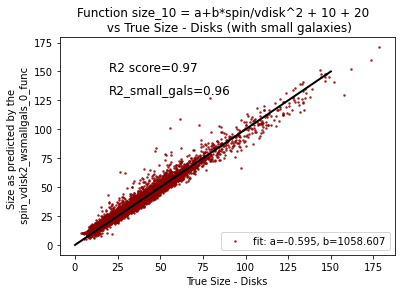

In [88]:
plt.scatter(Size, size_10, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_10))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(20, 150, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_10), size=12)
plt.text(20, 130, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_10, predicted_size_10)), size=12)
plt.title('Function size_10 = a+b*spin/vdisk^2 + 10 + 20  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_0_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_10_wsmallgals.jpeg', dpi=500)
plt.show()

In [89]:
size_small=[]
for i, j in enumerate(spin_vdisk[0]):
    print(i,j)
    if j <= 0.021:
        size_small.append(1*(j)*(1/ (spin_vdisk[1][i])**2))
    else:
        size_small.append(0.5 + 1058*j*(1/ (spin_vdisk[1][i])**2))
        

0 0.03407
1 0.03991
2 0.04671
3 0.02441
4 0.02365
5 0.07251
6 0.04816
7 0.02426
8 0.0298
9 0.02296
10 0.01363
11 0.0529
12 0.02967
13 0.03504
14 0.03115
15 0.02388
16 0.07683
17 0.02613
18 0.01408
19 0.02576
20 0.02015
21 0.04344
22 0.03438
23 0.02179
24 0.01219
25 0.03328
26 0.03996
27 0.09851
28 0.02238
29 0.04049
30 0.02543
31 0.02624
32 0.01156
33 0.06503
34 0.02694
35 0.0339
36 0.00855
37 0.03182
38 0.0797
39 0.07845
40 0.04476
41 0.06498
42 0.04449
43 0.02563
44 0.06845
45 0.01945
46 0.03862
47 0.00903
48 0.01615
49 0.04413
50 0.01993
51 0.02744
52 0.01909
53 0.03579
54 0.03311
55 0.07514
56 0.01965
57 0.03945
58 0.0185
59 0.01628
60 0.03805
61 0.00444
62 0.03841
63 0.01159
64 0.02384
65 0.03681
66 0.04951
67 0.02482
68 0.05398
69 0.04056
70 0.03771
71 0.03414
72 0.03399
73 0.02273
74 0.04461
75 0.04682
76 0.04338
77 0.06015
78 0.01715
79 0.0419
80 0.0286
81 0.03762
82 0.04167
83 0.04041
84 0.0205
85 0.02392
86 0.01185
87 0.04461
88 0.04967
89 0.0386
90 0.06766
91 0.03721
92 0.05

1460 0.01997
1461 0.04839
1462 0.01542
1463 0.06635
1464 0.03017
1465 0.01963
1466 0.05751
1467 0.05294
1468 0.01754
1469 0.03533
1470 0.01607
1471 0.05293
1472 0.06278
1473 0.04668
1474 0.04672
1475 0.02739
1476 0.0279
1477 0.02559
1478 0.02396
1479 0.01869
1480 0.02776
1481 0.01978
1482 0.04206
1483 0.01256
1484 0.04172
1485 0.01802
1486 0.03457
1487 0.03703
1488 0.06282
1489 0.03529
1490 0.02857
1491 0.03906
1492 0.03069
1493 0.02346
1494 0.05707
1495 0.01619
1496 0.03692
1497 0.02396
1498 0.03939
1499 0.02641
1500 0.03241
1501 0.0257
1502 0.07783
1503 0.02465
1504 0.04701
1505 0.04356
1506 0.04017
1507 0.02909
1508 0.0142
1509 0.0161
1510 0.04998
1511 0.0341
1512 0.05537
1513 0.02532
1514 0.01754
1515 0.01177
1516 0.06036
1517 0.06002
1518 0.0335
1519 0.07721
1520 0.02998
1521 0.04514
1522 0.01198
1523 0.03545
1524 0.02374
1525 0.08411
1526 0.01543
1527 0.01769
1528 0.05619
1529 0.02736
1530 0.0364
1531 0.03872
1532 0.03745
1533 0.03312
1534 0.10972
1535 0.03222
1536 0.0211
1537 0.

2960 0.02427
2961 0.01287
2962 0.0419
2963 0.03338
2964 0.01701
2965 0.01377
2966 0.01895
2967 0.0461
2968 0.02748
2969 0.03103
2970 0.0459
2971 0.01612
2972 0.04454
2973 0.06123
2974 0.04316
2975 0.03907
2976 0.04533
2977 0.05622
2978 0.02897
2979 0.03942
2980 0.0425
2981 0.06505
2982 0.04821
2983 0.03544
2984 0.02888
2985 0.00612
2986 0.0468
2987 0.01951
2988 0.06173
2989 0.0511
2990 0.0203
2991 0.02661
2992 0.02755
2993 0.0258
2994 0.03143
2995 0.02584
2996 0.01865
2997 0.02418
2998 0.03458
2999 0.0443
3000 0.03267
3001 0.01836
3002 0.02822
3003 0.02609
3004 0.02944
3005 0.01908
3006 0.06429
3007 0.06023
3008 0.01285
3009 0.02102
3010 0.03209
3011 0.04012
3012 0.02803
3013 0.051
3014 0.10382
3015 0.02921
3016 0.15455
3017 0.0613
3018 0.04985
3019 0.02287
3020 0.0093
3021 0.02128
3022 0.05892
3023 0.01529
3024 0.03612
3025 0.03047
3026 0.01766
3027 0.0291
3028 0.01082
3029 0.04526
3030 0.02017
3031 0.00905
3032 0.05623
3033 0.02838
3034 0.02758
3035 0.01094
3036 0.08331
3037 0.02528


4460 0.02225
4461 0.02792
4462 0.01811
4463 0.0153
4464 0.04173
4465 0.02753
4466 0.04202
4467 0.02156
4468 0.04403
4469 0.03973
4470 0.08978
4471 0.02096
4472 0.04271
4473 0.05432
4474 0.03027
4475 0.0411
4476 0.03273
4477 0.02572
4478 0.03432
4479 0.02732
4480 0.0432
4481 0.03827
4482 0.0245
4483 0.02406
4484 0.02584
4485 0.06339
4486 0.043
4487 0.02868
4488 0.0101
4489 0.01976
4490 0.02788
4491 0.03756
4492 0.02886
4493 0.04202
4494 0.03256
4495 0.02513
4496 0.02324
4497 0.0448
4498 0.04945
4499 0.03878
4500 0.02435
4501 0.09506
4502 0.05488
4503 0.04114
4504 0.06103
4505 0.04189
4506 0.062
4507 0.00564
4508 0.02381
4509 0.0185
4510 0.02504
4511 0.04279
4512 0.01615
4513 0.15627
4514 0.01165
4515 0.02746
4516 0.01369
4517 0.0298
4518 0.02705
4519 0.04259
4520 0.02057
4521 0.00809
4522 0.07131
4523 0.03759
4524 0.03843
4525 0.01301
4526 0.03361
4527 0.03179
4528 0.00811
4529 0.04298
4530 0.01566
4531 0.03457
4532 0.00277
4533 0.02468
4534 0.03611
4535 0.02346
4536 0.03622
4537 0.0582

5959 0.0292
5960 0.11356
5961 0.04998
5962 0.01514
5963 0.02733
5964 0.01878
5965 0.02801
5966 0.04542
5967 0.02346
5968 0.02979
5969 0.0204
5970 0.03908
5971 0.07945
5972 0.04747
5973 0.03381
5974 0.01174
5975 0.03822
5976 0.03437
5977 0.03556
5978 0.02742
5979 0.02837
5980 0.03312
5981 0.04545
5982 0.08268
5983 0.02254
5984 0.07288
5985 0.03324
5986 0.02602
5987 0.02718
5988 0.10602
5989 0.02935
5990 0.03584
5991 0.03866
5992 0.03845
5993 0.0209
5994 0.02355
5995 0.00824
5996 0.02673
5997 0.02198
5998 0.02635
5999 0.03091
6000 0.02839
6001 0.02445
6002 0.03131
6003 0.03018
6004 0.02322
6005 0.03584
6006 0.01912
6007 0.08847
6008 0.02131
6009 0.0162
6010 0.08804
6011 0.03966
6012 0.05223
6013 0.02249
6014 0.00809
6015 0.02541
6016 0.02515
6017 0.01851
6018 0.02188
6019 0.02764
6020 0.03074
6021 0.11153
6022 0.06511
6023 0.01649
6024 0.02912
6025 0.07412
6026 0.1233
6027 0.02576
6028 0.03087
6029 0.0159
6030 0.02712
6031 0.02204
6032 0.02316
6033 0.01533
6034 0.07328
6035 0.03578
6036 

7459 0.09881
7460 0.0263
7461 0.06754
7462 0.01603
7463 0.01655
7464 0.01784
7465 0.01869
7466 0.0476
7467 0.01354
7468 0.08417
7469 0.01587
7470 0.02921
7471 0.01549
7472 0.02695
7473 0.03853
7474 0.02809
7475 0.04883
7476 0.07375
7477 0.04004
7478 0.04467
7479 0.01819
7480 0.00923
7481 0.01054
7482 0.03602
7483 0.04358
7484 0.0191
7485 0.09889
7486 0.03613
7487 0.0426
7488 0.01637
7489 0.07649
7490 0.04397
7491 0.02753
7492 0.04759
7493 0.06994
7494 0.04423
7495 0.01343
7496 0.0263
7497 0.02553
7498 0.043
7499 0.02931
7500 0.02039
7501 0.0253
7502 0.01849
7503 0.0316
7504 0.02701
7505 0.03628
7506 0.03453
7507 0.01526
7508 0.03187
7509 0.01521
7510 0.05
7511 0.01904
7512 0.04353
7513 0.08133
7514 0.01974
7515 0.04137
7516 0.01722
7517 0.04838
7518 0.01557
7519 0.01459
7520 0.04727
7521 0.08008
7522 0.01297
7523 0.02776
7524 0.02807
7525 0.0336
7526 0.00531
7527 0.04433
7528 0.04178
7529 0.02881
7530 0.06225
7531 0.03723
7532 0.05049
7533 0.01481
7534 0.02705
7535 0.07835
7536 0.01177

8959 0.02918
8960 0.01235
8961 0.00799
8962 0.04485
8963 0.02775
8964 0.01509
8965 0.01526
8966 0.01599
8967 0.0393
8968 0.02649
8969 0.01754
8970 0.0307
8971 0.04752
8972 0.03598
8973 0.02993
8974 0.04078
8975 0.06962
8976 0.04099
8977 0.0204
8978 0.04119
8979 0.03694
8980 0.02617
8981 0.026
8982 0.02768
8983 0.02259
8984 0.02958
8985 0.04874
8986 0.02108
8987 0.06826
8988 0.04743
8989 0.02202
8990 0.04876
8991 0.04389
8992 0.02961
8993 0.03817
8994 0.05909
8995 0.02452
8996 0.01641
8997 0.04148
8998 0.03342
8999 0.06281
9000 0.05492
9001 0.02819
9002 0.01858
9003 0.02201
9004 0.01924
9005 0.05403
9006 0.01644
9007 0.02638
9008 0.10088
9009 0.02315
9010 0.02453
9011 0.00665
9012 0.05462
9013 0.0553
9014 0.01615
9015 0.00944
9016 0.02033
9017 0.01489
9018 0.049
9019 0.02243
9020 0.04083
9021 0.0292
9022 0.01657
9023 0.11249
9024 0.04719
9025 0.01278
9026 0.03849
9027 0.03166
9028 0.1073
9029 0.02343
9030 0.01063
9031 0.03461
9032 0.01732
9033 0.02472
9034 0.01861
9035 0.00704
9036 0.06

10209 0.03657
10210 0.00915
10211 0.01852
10212 0.00617
10213 0.01986
10214 0.03931
10215 0.04881
10216 0.03217
10217 0.01999
10218 0.03132
10219 0.03218
10220 0.04015
10221 0.0222
10222 0.05055
10223 0.01501
10224 0.01346
10225 0.03122
10226 0.06793
10227 0.08818
10228 0.0502
10229 0.07708
10230 0.04598
10231 0.02796
10232 0.02986
10233 0.02104
10234 0.06773
10235 0.03756
10236 0.032
10237 0.01955
10238 0.02128
10239 0.02288
10240 0.04514
10241 0.03562
10242 0.02767
10243 0.02284
10244 0.06663
10245 0.01819
10246 0.03288
10247 0.01767
10248 0.01559
10249 0.03097
10250 0.02834
10251 0.03664
10252 0.06529
10253 0.05946
10254 0.01088
10255 0.03304
10256 0.06483
10257 0.03933
10258 0.07995
10259 0.00956
10260 0.01985
10261 0.06947
10262 0.03684
10263 0.03724
10264 0.014
10265 0.05027
10266 0.0367
10267 0.04805
10268 0.03758
10269 0.00831
10270 0.02624
10271 0.04932
10272 0.01755
10273 0.06328
10274 0.12297
10275 0.01241
10276 0.0299
10277 0.0352
10278 0.01082
10279 0.0147
10280 0.04084
10

11958 0.03604
11959 0.03784
11960 0.01516
11961 0.07117
11962 0.02529
11963 0.01943
11964 0.04863
11965 0.03062
11966 0.0078
11967 0.08768
11968 0.0249
11969 0.03278
11970 0.0346
11971 0.02554
11972 0.01062
11973 0.02932
11974 0.08145
11975 0.02778
11976 0.04334
11977 0.03164
11978 0.05415
11979 0.03802
11980 0.02651
11981 0.02991
11982 0.04938
11983 0.03987
11984 0.06007
11985 0.06242
11986 0.05497
11987 0.02792
11988 0.01947
11989 0.04835
11990 0.02513
11991 0.03674
11992 0.06107
11993 0.05155
11994 0.02624
11995 0.0396
11996 0.00774
11997 0.0545
11998 0.04003
11999 0.03708
12000 0.03145
12001 0.04801
12002 0.03837
12003 0.0736
12004 0.0185
12005 0.02544
12006 0.02616
12007 0.03771
12008 0.00318
12009 0.06231
12010 0.01978
12011 0.02464
12012 0.01646
12013 0.0396
12014 0.00329
12015 0.03872
12016 0.05224
12017 0.05428
12018 0.01746
12019 0.04166
12020 0.03118
12021 0.04004
12022 0.0272
12023 0.0437
12024 0.04018
12025 0.0288
12026 0.04706
12027 0.00591
12028 0.02402
12029 0.05872
120

13708 0.02528
13709 0.01733
13710 0.01742
13711 0.03877
13712 0.02765
13713 0.00471
13714 0.00909
13715 0.04844
13716 0.07205
13717 0.07114
13718 0.03709
13719 0.03508
13720 0.02691
13721 0.03877
13722 0.04853
13723 0.05625
13724 0.05474
13725 0.05445
13726 0.06995
13727 0.02242
13728 0.06976
13729 0.02492
13730 0.05044
13731 0.01346
13732 0.0191
13733 0.0189
13734 0.0432
13735 0.01857
13736 0.03921
13737 0.05733
13738 0.02082
13739 0.08933
13740 0.02869
13741 0.02265
13742 0.03791
13743 0.02474
13744 0.05104
13745 0.02649
13746 0.05147
13747 0.05285
13748 0.02962
13749 0.02736
13750 0.02161
13751 0.0425
13752 0.03475
13753 0.00694
13754 0.01569
13755 0.02698
13756 0.03496
13757 0.05033
13758 0.03664
13759 0.01517
13760 0.02498
13761 0.01813
13762 0.07235
13763 0.08268
13764 0.025
13765 0.01604
13766 0.0161
13767 0.07695
13768 0.06703
13769 0.06172
13770 0.04894
13771 0.0286
13772 0.04233
13773 0.06278
13774 0.0291
13775 0.05052
13776 0.03825
13777 0.01259
13778 0.06516
13779 0.12888
1

15289 0.03376
15290 0.05056
15291 0.02802
15292 0.01426
15293 0.03884
15294 0.02888
15295 0.13841
15296 0.05885
15297 0.03098
15298 0.01264
15299 0.05034
15300 0.02318
15301 0.04449
15302 0.02279
15303 0.12215
15304 0.0318
15305 0.02973
15306 0.02491
15307 0.06261
15308 0.03436
15309 0.02622
15310 0.03834
15311 0.02598
15312 0.00698
15313 0.05131
15314 0.02638
15315 0.04426
15316 0.01702
15317 0.04071
15318 0.01968
15319 0.0387
15320 0.05945
15321 0.03281
15322 0.03676
15323 0.03341
15324 0.03966
15325 0.01531
15326 0.02286
15327 0.03708
15328 0.02801
15329 0.04364
15330 0.004
15331 0.04477
15332 0.03324
15333 0.02561
15334 0.03432
15335 0.06697
15336 0.02115
15337 0.0698
15338 0.01972
15339 0.05791
15340 0.04056
15341 0.01757
15342 0.00556
15343 0.01737
15344 0.04064
15345 0.03975
15346 0.03012
15347 0.04481
15348 0.03714
15349 0.04394
15350 0.0312
15351 0.03938
15352 0.03418
15353 0.034
15354 0.01974
15355 0.03629
15356 0.04457
15357 0.02298
15358 0.02816
15359 0.03803
15360 0.0244
1

In [90]:
list(zip(spin_vdisk[0], spin_vdisk[1]))

size_small=[]
for spin, vdisk in zip(spin_vdisk[0], spin_vdisk[1]):
    #print(spin, vdisk)
    if spin <= 0.021:
        size_small.append(1*(spin)*(1/ (vdisk)**2))
    else:
        size_small.append(0.5 + 1058*spin*(1/ (vdisk)**2))
size_small       

[21.808821198551996,
 43.31497649695209,
 50.610030091597125,
 17.675294574279746,
 16.087689637681862,
 51.29200106252924,
 34.75663168661964,
 26.525862840194613,
 32.46908364947652,
 25.131223480324394,
 0.009292283461093457,
 39.55815442553034,
 19.6527937374557,
 28.58489578352878,
 20.397425958724437,
 15.575556834285056,
 59.31482523478887,
 16.907377405842716,
 0.014276771395988229,
 28.135027598234746,
 0.020431670063701467,
 47.10190531377388,
 22.989672798016972,
 23.87606406361592,
 0.012360418995371302,
 18.687767096595305,
 29.42767076337039,
 68.21073911539007,
 24.508993248749725,
 29.743421396392602,
 27.780958601302977,
 28.649930498564196,
 0.011721574699229497,
 37.97679702268364,
 29.400908954073774,
 36.86752678347581,
 0.00866950530005587,
 34.636151986659165,
 49.202600610336916,
 51.74613011533295,
 36.293699949610385,
 70.20970167435755,
 48.228321150874685,
 27.995586876879532,
 40.39104922078423,
 0.01972184575682374,
 41.93102478135046,
 0.00241171655210782

In [91]:
size_small=[0]*len(spin_vdisk[0])

size_big=[]
# for i in range(len(spin_vdisk[0])):
for i in range(15716):


    print(i)
    if spin_vdisk[0][i] <= 0.021:
        # how do I access the corresponding vdisk values for each spin=0.021 case in a 2,M array?
        size_small[i] = 1*(spin_vdisk[0][i])*(1/ (spin_vdisk[1][i])**2) 
    elif spin_vdisk[0][i] > 0.021 :
        size_small[i] = 0.5 + 1058*spin_vdisk[0][i]*(1/ (spin_vdisk[1][i])**2)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667


5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666


8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666


11966
11967
11968
11969
11970
11971
11972
11973
11974
11975
11976
11977
11978
11979
11980
11981
11982
11983
11984
11985
11986
11987
11988
11989
11990
11991
11992
11993
11994
11995
11996
11997
11998
11999
12000
12001
12002
12003
12004
12005
12006
12007
12008
12009
12010
12011
12012
12013
12014
12015
12016
12017
12018
12019
12020
12021
12022
12023
12024
12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
1213

15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15485
15486
15487
15488
15489
15490
15491
15492
15493
15494
15495
15496
15497
15498
15499
15500
15501
15502
15503
15504
15505
15506
15507
15508
15509
15510
15511
15512
15513
15514
15515
15516
15517
15518
15519
15520
15521
15522
15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
1563

### case 11: size_11 = spin/vdisk^2 + f(spin=0.02, vdisk) small galaxy sizes

In [92]:
def spin_vdisk2_wsmallgals_1_func(spin_vdisk, a, b, c, d):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    
    size = a + b*spin_vdisk[0]*(1/ (spin_vdisk[1])**2)
    size_small_20 = c*spin_vdisk[1]
    size_small_10 = d*spin_vdisk[1]
    
    # I want to define here a size value for spin=0.02 depending on vdisk values, but how?
#     size_filter = (spin_vdisk[0] <= 0.021)
#     size_inverse_filter = (size_filter == False)

    size_20_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)==0.993)
    size_20_inverse_filter = size_20_filter == False
    
    size_10_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)!=0.993)
    size_10_inverse_filter = size_10_filter == False


    
    # substitute size 20 in corresponding indices    
    size  = size_small_20 * size_20_filter + size * size_20_inverse_filter
    # substitute size 10 in corresponding indices    
    size  = size_small_10 * size_10_filter + size * size_10_inverse_filter


    
    # substitute size_small in corresponding indices    
#     size  = size_small * size_filter + size_big * size_inverse_filter
    # 
    return size

In [93]:
popt_11, pcov_11 = curve_fit(spin_vdisk2_wsmallgals_1_func, spin_vdisk, Size)

size_11 = spin_vdisk2_wsmallgals_1_func(spin_vdisk, *popt_11)

In [94]:
df_spin_size_10 = df_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_10["Predicted"] = size_10
zz_10 = df_spin_size_10[df_spin_size_10['HalopropSpin']<=0.021]
actual_size_10 = zz_10['GalpropNormHalfRadius']
predicted_size_10 = zz_10['Predicted']
r2_score(actual_size_10, predicted_size_10)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/2166060701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_10["Predicted"] = size_10


0.8515392963019432

In [95]:
df_spin_size_11 = df_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_11["Predicted"] = size_11
zz_11 = df_spin_size_11[df_spin_size_11['HalopropSpin']<=0.021]
actual_size_11 = zz_11['GalpropNormHalfRadius']
predicted_size_11 = zz_11['Predicted']
r2_score(actual_size_11, predicted_size_11)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/495573772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_11["Predicted"] = size_11


0.9343603263232672

In [96]:
r2_score_size_funcsize_11=r2_score(Size, size_11)
r2_score_size_funcsize_11

0.9689387734804772

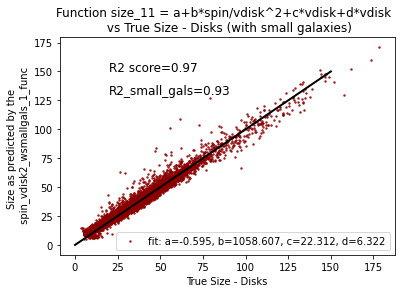

In [97]:
plt.scatter(Size, size_11, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt_11))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(20, 150, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_11), size=12)
plt.text(20, 130, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_11, predicted_size_11)), size=12)
plt.title('Function size_11 = a+b*spin/vdisk^2+c*vdisk+d*vdisk  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_1_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_11_wsmallgals.jpeg', dpi=500)
plt.show()

### case 12: size_12 = spin/vdisk^2 + f(spin=0.02, 1/vdisk^2) small galaxy sizes


In [98]:
def spin_vdisk2_wsmallgals_2_func(spin_vdisk, a, b, c):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    
    size_big = a + b*spin_vdisk[0]*(1/ (spin_vdisk[1])**2)
    size_small = c*(1/spin_vdisk[1]**2)


#     size_small_20 = c*(1/spin_vdisk[1]**2)
#     size_small_10 = d*(1/spin_vdisk[1]**2)
    
    # I want to define here a size value for spin=0.02 depending on vdisk values, but how?
    size_filter = (spin_vdisk[0] <= 0.021)
    size_inverse_filter = (size_filter == False)

#     size_20_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)==0.993)
#     size_20_inverse_filter = size_20_filter == False
    
#     size_10_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)!=0.993)
#     size_10_inverse_filter = size_10_filter == False


    
#     # substitute size 20 in corresponding indices    
#     size  = size_small_20 * size_20_filter + size * size_20_inverse_filter
#     # substitute size 10 in corresponding indices    
#     size  = size_small_10 * size_10_filter + size * size_10_inverse_filter


    
    # substitute size_small in corresponding indices    
    size  = size_small * size_filter + size_big * size_inverse_filter
    # 
    return size

In [99]:
popt_12, pcov_12 = curve_fit(spin_vdisk2_wsmallgals_2_func, spin_vdisk, Size)

size_12 = spin_vdisk2_wsmallgals_2_func(spin_vdisk, *popt_12)

In [100]:
df_spin_size_12 = df_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_12["Predicted"] = size_12
zz_12 = df_spin_size_12[df_spin_size_12['HalopropSpin']<=0.021]
actual_size_12 = zz_12['GalpropNormHalfRadius']
predicted_size_12 = zz_12['Predicted']
r2_score(actual_size_12, predicted_size_12)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/2697028262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_12["Predicted"] = size_12


0.882576767171375

In [101]:
r2_score_size_funcsize_12=r2_score(Size, size_12)
r2_score_size_funcsize_12

0.9672965883031868

Note: When I use functions

    size_small_20 = c*(spin_vdisk[0]/spin_vdisk[1]**2)
    size_small_10 = d*(spin_vdisk[0]/spin_vdisk[1]**2)
    
 for small galaxies, I get c=1358.5 and d=959.9.
 The R score is very low for these small galaxies in this case, R2_small=0.12. The R score of the whole model becomes R2=0.94.

However, when I use functions

    size_small_20 = c*(1/spin_vdisk[1]**2)
    size_small_10 = d*(1/spin_vdisk[1]**2)
 
for small galaxies, I get c=21.9 and d=15.4. The R score increases drastically for small galaxies to R2_small=0.973. The R score of the whole model increases to R2=0.97.

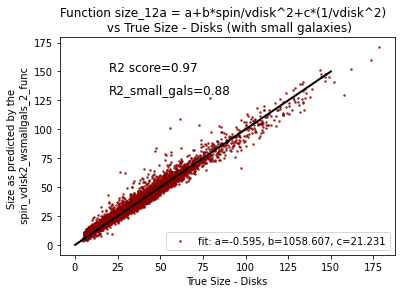

In [102]:
plt.scatter(Size, size_12, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_12))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(20, 150, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_12), size=12)
plt.text(20, 130, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_12, predicted_size_12)), size=12)
plt.title('Function size_12a = a+b*spin/vdisk^2+c*(1/vdisk^2)  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_2_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_12a_wsmallgals.jpeg', dpi=500)
plt.show()

### case 13: size_13 = spin/vdisk^2 + f(spin=0.02, spin/vdisk^2) small galaxy sizes

In [103]:
def spin_vdisk2_wsmallgals_3_func(spin_vdisk, a, b, c, d):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    
    size = a + b*spin_vdisk[0]*(1/ (spin_vdisk[1])**2)
    size_small_20 = c*(spin_vdisk[0]/spin_vdisk[1]**2)
    size_small_10 = d*(spin_vdisk[0]/spin_vdisk[1]**2)
    

    size_20_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)==0.993)
    size_20_inverse_filter = size_20_filter == False
    
    size_10_filter = (spin_vdisk[0] <= 0.021) & (spin_vdisk[1].round(3)!=0.993)
    size_10_inverse_filter = size_10_filter == False


    
    # substitute size 20 in corresponding indices    
    size  = size_small_20 * size_20_filter + size * size_20_inverse_filter
    # substitute size 10 in corresponding indices    
    size  = size_small_10 * size_10_filter + size * size_10_inverse_filter


    
    # substitute size_small in corresponding indices    
#     size  = size_small * size_filter + size_big * size_inverse_filter
    # 
    return size

In [104]:
popt_13, pcov_13 = curve_fit(spin_vdisk2_wsmallgals_3_func, spin_vdisk, Size)

size_13 = spin_vdisk2_wsmallgals_3_func(spin_vdisk, *popt_13)

In [105]:
df_spin_size_13 = df_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_13["Predicted"] = size_13
zz_13 = df_spin_size_13[df_spin_size_13['HalopropSpin']<=0.021]
actual_size_13 = zz_13['GalpropNormHalfRadius']
predicted_size_13 = zz_13['Predicted']
r2_score(actual_size_13, predicted_size_13)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/2217109240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_13["Predicted"] = size_13


0.11645191079991735

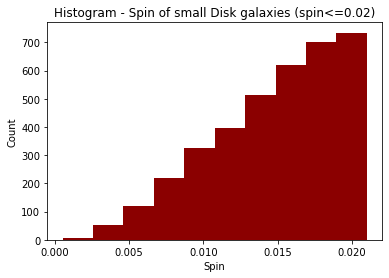

In [106]:
plt.hist(zz_13['HalopropSpin'], color='darkred')
plt.title('Histogram - Spin of small Disk galaxies (spin<=0.02)')
plt.ylabel('Count')
plt.xlabel('Spin')
# plt.savefig('Disks Histogram of Spin of small galaxies.jpeg', dpi=500)
plt.show()

In [107]:
zz_13['HalopropSpin'].max()

0.021

In [108]:
zz_13['HalopropSpin'].min()

0.00053

In [109]:
r2_score_size_funcsize_13=r2_score(Size, size_13)
r2_score_size_funcsize_13

0.9430008677368078

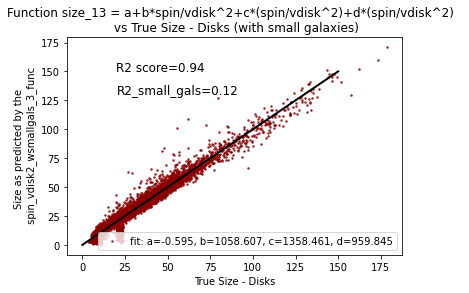

In [110]:
plt.scatter(Size, size_13, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt_13))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(20, 150, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_13), size=12)
plt.text(20, 130, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_13, predicted_size_13)), size=12)
plt.title('Function size_13 = a+b*spin/vdisk^2+c*(spin/vdisk^2)+d*(spin/vdisk^2)  \n vs True Size - Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_3_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_13_wsmallgals.jpeg', dpi=500)
plt.show()

### case 14: size_14 = a+b*spin/vdisk^2  where spin=spin_min for small galaxy sizes

In [111]:
def spin_vdisk2_wsmallgals_4_func(spin_vdisk, a, b, spin_min):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    
    spin_use = np.copy(spin_vdisk[0])
    vdisk = np.copy(spin_vdisk[1])
    spin_use[spin_use < spin_min] = spin_min
    
    size = a + b*spin_use/vdisk**2

    return size

In [112]:
popt_14, pcov_14 = curve_fit(spin_vdisk2_wsmallgals_4_func, spin_vdisk, Size, p0=[0.5, 1000, 0.002])

size_14 = spin_vdisk2_wsmallgals_4_func(spin_vdisk, *popt_14)

In [113]:
popt_14

array([-1.05157368e+00,  1.07009714e+03,  2.08615207e-02])

In [115]:
df_spin_size_14 = df_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_14["Predicted"] = size_14
zz_14 = df_spin_size_14[df_spin_size_14['HalopropSpin']<=0.021]
actual_size_14 = zz_14['GalpropNormHalfRadius']
predicted_size_14 = zz_14['Predicted']
r2_score(actual_size_14, predicted_size_14)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/2656566128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_14["Predicted"] = size_14


0.9002234198732552

In [116]:
r2_score_size_funcsize_14=r2_score(Size, size_14)
r2_score_size_funcsize_14

0.9677484178106694

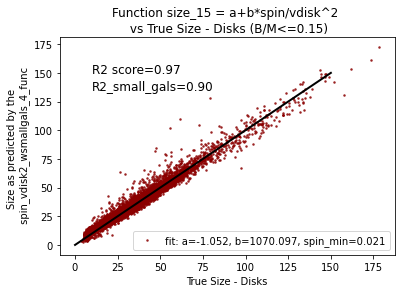

In [295]:
plt.scatter(Size, size_14, marker='.', s=10, alpha=0.7, c = 'darkred',
        label='fit: a=%5.3f, b=%5.3f, spin_min=%5.3f' % tuple(popt_14))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,150, 0.0,150])
plt.text(10, 150, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_14), size=12)
plt.text(10, 135, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_14, predicted_size_14)), size=12)
plt.title('Function size_15 = a+b*spin/vdisk^2 \n vs True Size - Disks (B/M<=0.15)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_4_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =20> </a> <br> 2. Bulgy Disk Galaxies: 0.15< B/Mstar <=0.3

In [121]:
df_bulgy_disks = pd.read_csv('Bulgy Disks Dataset_as defined in notebook v13')

In [122]:
df_bulgy_disks.shape

(12949, 33)

In [123]:
X_bulgy_disks = df_bulgy_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_bulgy_disks = df_bulgy_disks.loc[:,'GalpropNormHalfRadius']

In [124]:
# choose the 7 most important features from analysis above to be used for physical modelling

X_bulgy_disks_imp = df_bulgy_disks.loc[:, ['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormSigmaBulge', 'HalopropC_nfw', 'GalpropNormMcold',
                              'GalpropTmerger', 'GalpropOutflowRate_Metal' ]]


y_bulgy_disks_imp = df_bulgy_disks.loc[:, 'GalpropNormHalfRadius']

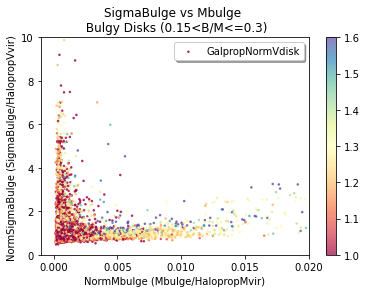

In [125]:
plt.scatter(df_bulgy_disks.loc[:,'GalpropNormMbulge'], df_bulgy_disks.loc[:, 'GalpropNormSigmaBulge'],
            c = df_bulgy_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-0.001,0.02, 0.0,10])
plt.title('SigmaBulge vs Mbulge \n Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('NormMbulge (Mbulge/HalopropMvir)')
plt.ylabel('NormSigmaBulge (SigmaBulge/HalopropVvir) ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('BulgyDisks_SigmaBulge_vs_Mbulge_vdiskcolor.jpeg', dpi=500)
plt.show() 

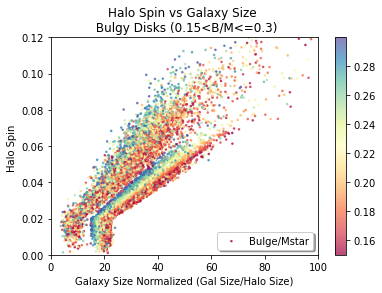

In [126]:
plt.scatter(y_bulgy_disks_imp, X_bulgy_disks_imp.loc[:, 'HalopropSpin'],
            c = df_bulgy_disks['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'Bulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_bulgy_disks_bulgemstarcolor.jpeg', dpi=500)
plt.show()

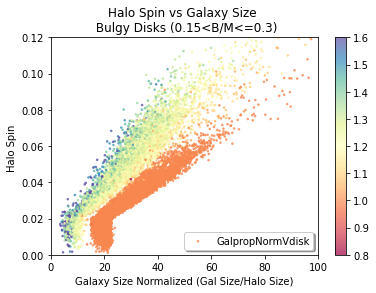

In [127]:
plt.scatter(df_bulgy_disks.loc[:,'GalpropNormHalfRadius'], df_bulgy_disks.loc[:, 'HalopropSpin'],
            c = df_bulgy_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.8, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('BulgyDisks_Spin_vs_Size_vdiskcolor.jpeg', dpi=500)
plt.show()

In [128]:
df_bulgy_small = df_bulgy_disks[df_bulgy_disks['HalopropSpin']<=0.021]

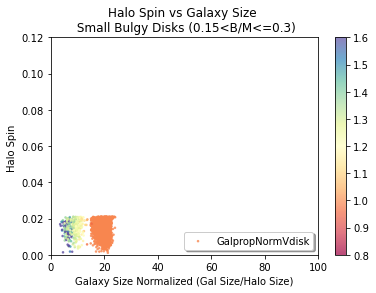

In [129]:
plt.scatter(df_bulgy_small.loc[:,'GalpropNormHalfRadius'], df_bulgy_small.loc[:, 'HalopropSpin'],
            c = df_bulgy_small['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.8, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Small Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('BulgyDisks_Spin_vs_Size_vdiskcolor.jpeg', dpi=500)
plt.show()

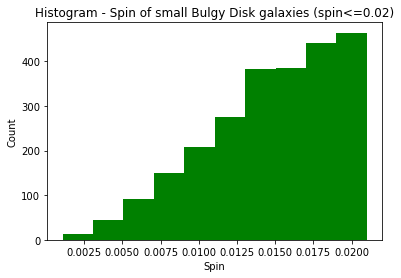

In [130]:
plt.hist(df_bulgy_small['HalopropSpin'], color='green')
plt.title('Histogram - Spin of small Bulgy Disk galaxies (spin<=0.02)')
plt.ylabel('Count')
plt.xlabel('Spin')
# plt.savefig('BulgyDisks Histogram of Spin of small galaxies.jpeg', dpi=500)
plt.show()

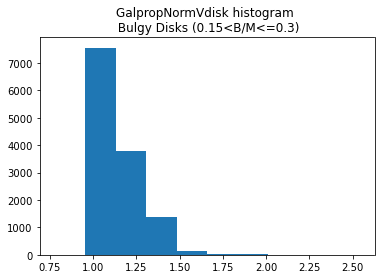

In [131]:
plt.hist(df_bulgy_disks['GalpropNormVdisk'])
plt.title('GalpropNormVdisk histogram \n Bulgy Disks (0.15<B/M<=0.3)')
# plt.savefig('GalpropNormVdisk_bulgy_disks_histogram', dpi=500)
plt.show()

In [132]:
df_bulgy_disks_wosmallgalaxies = df_bulgy_disks.loc[df_bulgy_disks.GalpropNormHalfRadius > 20]



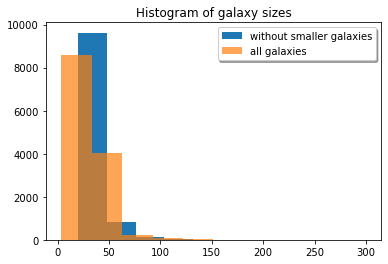

In [133]:
plt.hist (df_bulgy_disks_wosmallgalaxies['GalpropNormHalfRadius'], label = 'without smaller galaxies')
plt.hist (df_bulgy_disks['GalpropNormHalfRadius'], alpha=0.7, label = 'all galaxies')
plt.title ('Histogram of galaxy sizes')
plt.legend (loc='upper right' , shadow=True)
plt.show()

#### Define the 2,M array for Bulgy Disks to use in curve_fit

In [134]:
Size_bulgy = np.array(df_bulgy_disks['GalpropNormHalfRadius'])

HalopropSpin_bulgy = df_bulgy_disks.loc[:, 'HalopropSpin']

HalopropSpin_bulgy = np.array(HalopropSpin_bulgy)

HalopropSpin_bulgy

GalpropNormVdisk_bulgy = df_bulgy_disks.loc[:, 'GalpropNormVdisk']

GalpropNormVdisk_bulgy = np.array(GalpropNormVdisk_bulgy)

GalpropNormVdisk_bulgy

### case 0: using size_0 = a+b*spin+c*vdisk+d*spin*vdisk equation from Disks on Bulgy Disks

In [306]:
spin_vdisk_bulgy = [HalopropSpin_bulgy, GalpropNormVdisk_bulgy]
spin_vdisk_bulgy = np.array (spin_vdisk_bulgy) # convert list into array

In [307]:
# check if equation 0 from Disks population can predict sizes of Bulgy Disks
size_0_bulgy = spin_vdisk_func(spin_vdisk_bulgy, *popt)

In [308]:
r2_score_size_funcsize_0_bulgy=r2_score(Size_bulgy, size_0_bulgy)

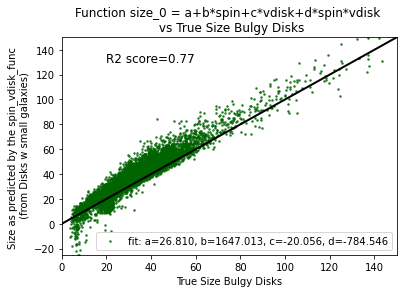

In [309]:
plt.scatter(Size_bulgy, size_0_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_0_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_0 = a+b*spin+c*vdisk+d*spin*vdisk \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the spin_vdisk_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend()
# plt.savefig('BulgyDisks_TrueSize_vs_Size_0_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 1: Using size_1 = a + b*spin + d*spin*vdisk equation from Disks on Bulgy Disks

In [145]:
size_1_bulgy = spin_vdisk_func_1(spin_vdisk_bulgy, *popt_1)

In [146]:
r2_score_size_funcsize_1_bulgy=r2_score(Size_bulgy, size_1_bulgy)

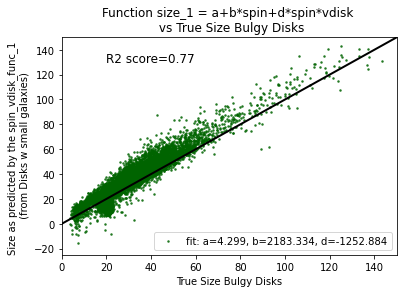

In [147]:
plt.scatter(Size_bulgy, size_1_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f' % tuple(popt_1))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_1_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)

plt.title('Function size_1 = a+b*spin+d*spin*vdisk \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the spin_vdisk_func_1 \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_1_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 2: Using size_2 = spin/vdisk equation from Disks on Bulgy Disks

In [148]:
size_2_bulgy = spin_over_vdisk_func(spin_vdisk_bulgy, *popt_2)

In [149]:
r2_score_size_funcsize_2_bulgy=r2_score(Size_bulgy, size_2_bulgy)

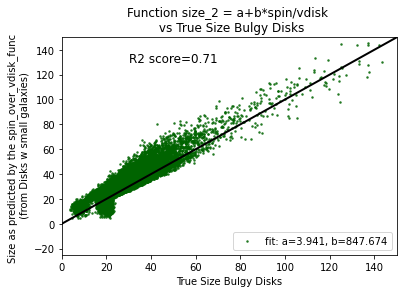

In [150]:
plt.scatter(Size_bulgy, size_2_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_2))
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_2_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)

plt.title('Function size_2 = a+b*spin/vdisk \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the spin_over_vdisk_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_2_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 3: Using size_3 = spin/vdisk^2 equation (the function predicted by SR) from Disks on Bulgy Disks


In [151]:
size_3_bulgy = spin_over_vdisk_squared_func(spin_vdisk_bulgy, *popt_3)

In [152]:
r2_score_size_funcsize_3_bulgy=r2_score(Size_bulgy, size_3_bulgy)

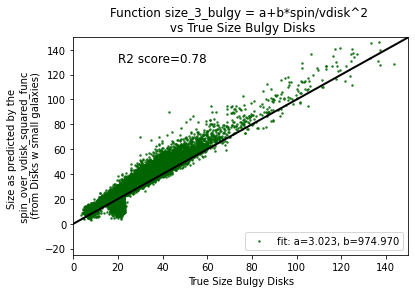

In [153]:
plt.scatter(Size_bulgy, size_3_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_3))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_3_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_3_bulgy = a+b*spin/vdisk^2 \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_3_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 3a: Using size_3a = spin/vdisk^2 equation (the function predicted by SR for Bulgy Disks)

In [154]:
# The SR best eqution for Bulgy Disks with n_iter=100: 914.50977*HalopropSpin/GalpropNormVdisk**2
size_3a_bulgy = 914.50977*HalopropSpin_bulgy/(GalpropNormVdisk_bulgy**2)

In [155]:
r2_score_size_funcsize_3a_bulgy=r2_score(Size_bulgy, size_3a_bulgy)

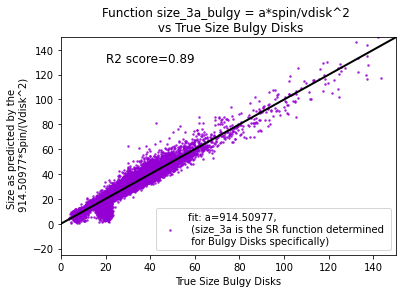

In [156]:
plt.scatter(Size_bulgy, size_3a_bulgy, marker='.', s=10, alpha=0.7, c='darkviolet',
        label='fit: a=914.50977, \n (size_3a is the SR function determined \n for Bulgy Disks specifically)')
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_3a_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_3a_bulgy = a*spin/vdisk^2 \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n 914.50977*Spin/(Vdisk^2)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_3a__all_vdisk_values.jpeg', dpi=500)
plt.show()

### case 4: Using size_4 = a + b*spin + d*spin*vdisk + e*(Mbulge/Mstar) from Disks on Bulgy Disks


In [157]:
BulgeMstar_bulgy = np. array(df_bulgy_disks.loc[:, 'BulgeMstar_ratio'])

In [158]:
spin_vdisk_bmstar_bulgy = [HalopropSpin_bulgy, GalpropNormVdisk_bulgy, BulgeMstar_bulgy]

In [159]:
spin_vdisk_bmstar_bulgy  = np.array (spin_vdisk_bmstar_bulgy )

In [160]:
size_4_bulgy = spin_vdisk_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_4)

In [161]:
r2_score_size_funcsize_4_bulgy=r2_score(Size_bulgy, size_4_bulgy)

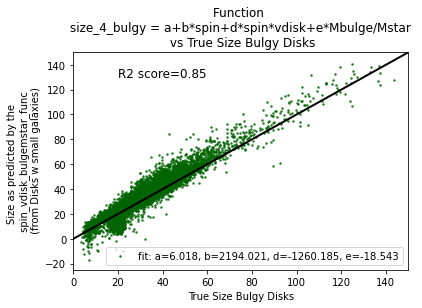

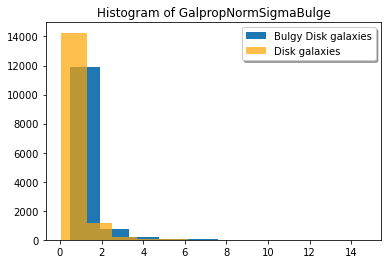

In [162]:
plt.scatter(Size_bulgy, size_4_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt_4))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_4_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function \n size_4_bulgy = a+b*spin+d*spin*vdisk+e*Mbulge/Mstar \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n spin_vdisk_bulgemstar_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_4_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

plt.hist(df_bulgy_disks['GalpropNormSigmaBulge'], label = 'Bulgy Disk galaxies')
plt.hist(df_disks['GalpropNormSigmaBulge'], alpha=0.7, color = 'orange', label = 'Disk galaxies')
plt.title ('Histogram of GalpropNormSigmaBulge')
plt.legend (loc='upper right' , shadow=True)
# plt.savefig('Disks_vs_BulgyDisks_GalpropNormSigmaBulge_histogram.jpeg', dpi=500)
plt.show()

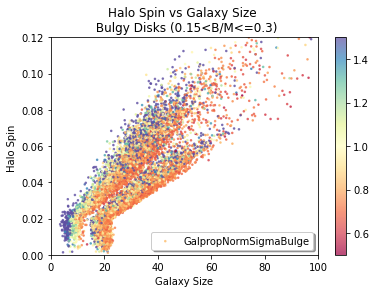

In [163]:
plt.scatter(y_bulgy_disks_imp, X_bulgy_disks_imp.loc[:, 'HalopropSpin'],
            c = df_bulgy_disks['GalpropNormSigmaBulge'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormSigmaBulge', vmin=0.5, vmax=1.5)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('Galaxy Size')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_bulgy_disks_sigmabulgecolor_scaleconstrained.jpeg', dpi=500)
plt.show()

### Relative Error for function size_4 = a + b*spin + d*spin*vdisk + e*(Mbulge/Mstar) 

In [164]:
relative_error_4_bulgy = (size_4_bulgy - Size_bulgy)/Size_bulgy

In [165]:
df_bulgy_disks_relerr = df_bulgy_disks

In [166]:
df_bulgy_disks_relerr.shape

(12949, 33)

In [167]:
df_bulgy_disks_relerr['Relative Error'] = relative_error_4_bulgy

In [168]:
df_bulgy_disks_relerr.shape

(12949, 34)

In [169]:
df_bulgy_disks_relerr_sample = df_bulgy_disks_relerr.sample(n = 1000, random_state = 2022)

In [170]:
df_bulgy_disks_relerr_sample.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMaccdot_radio', 'GalpropMu_merger', 'GalpropOutflowRate_Mass',
       'GalpropOutflowRate_Metal', 'GalpropSfr', 'GalpropSfrave100myr',
       'GalpropSfrave1gyr', 'GalpropSfrave20myr', 'GalpropTmerger',
       'GalpropTmerger_major', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate',
       'HalopropMetal_ejected', 'HalopropSpin', 'HalopropZhot',
       'GalpropNormHalfRadius', 'GalpropNormMstar', 'HalopropNormMhot',
       'GalpropNormMbulge', 'GalpropNormMBH', 'GalpropNormMH2',
       'GalpropNormMHI', 'GalpropNormMHII', 'GalpropNormMcold',
       'GalpropNormMstar_merge', 'HalopropNormMass_ejected',
       'HalopropNormMstar_diffuse', 'GalpropNormSigmaBulge',
       'GalpropNormVdisk', 'BulgeMstar_ratio', 'Relative Error'],
      dtype='object')>

In [171]:
df_bulgy_disks_relerr_sample = df_bulgy_disks_relerr_sample.loc[:, ['HalopropSpin',                                                 
                            'GalpropNormVdisk', 'GalpropNormSigmaBulge', 'HalopropC_nfw', 'GalpropNormMcold',
                            'GalpropTmerger', 'GalpropOutflowRate_Metal', 'HalopropNormMstar_diffuse',
                            'GalpropNormMbulge', 'GalpropTmerger_major', 'HalopropMetal_ejected',
                             'GalpropNormMstar', 'GalpropNormMHI', 'GalpropNormHalfRadius',
                             'BulgeMstar_ratio', 'Relative Error']]

In [172]:
df_bulgy_disks_relerr_sample.shape

(1000, 16)

### Size vs C_nfw

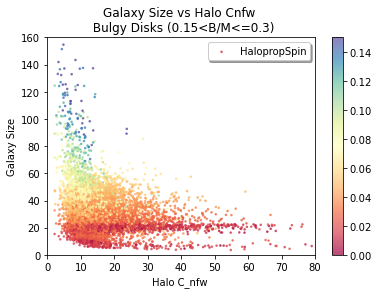

In [173]:
plt.scatter( X_bulgy_disks_imp.loc[:, 'HalopropC_nfw'], y_bulgy_disks_imp,
            c = df_bulgy_disks['HalopropSpin'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'HalopropSpin', vmin=0.0, vmax=0.15)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,80, 0.0,160])
plt.title('Galaxy Size vs Halo Cnfw \n Bulgy Disks (0.15<B/M<=0.3)')
plt.ylabel('Galaxy Size')
plt.xlabel('Halo C_nfw ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('Size_vs_Cnfw_bulgy_disks_spincolor_scaleconstrained.jpeg', dpi=500)
plt.show()

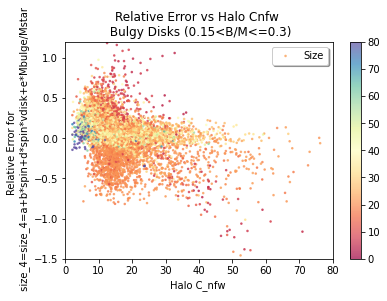

In [174]:
plt.scatter(X_bulgy_disks_imp.loc[:, 'HalopropC_nfw'], relative_error_4_bulgy,
            c = df_bulgy_disks['GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'Size', vmin=0.0, vmax=80)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,80, -1.5,1.2])
plt.title('Relative Error vs Halo Cnfw \n Bulgy Disks (0.15<B/M<=0.3)')
plt.ylabel('Relative Error for \n size_4=size_4=a+b*spin+d*spin*vdisk+e*Mbulge/Mstar')
plt.xlabel('Halo C_nfw ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('RelativeError4_vs_Cnfw_bulgy_disks_sizecolor_scaleconstrained.jpeg', dpi=500)
plt.show()

### Relative Error vs Halo Mass - is there dependence on Halo Mass?

In [175]:
# Load the raw TNG-SAM dataset (after analysis done on notebook v5)
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

In [176]:
df_log_mass_filtered_v5.shape

(35390, 66)

In [177]:
# add the Bulge/Mstar ratio column to the raw dataset
df_log_mass_filtered_v5.loc[:, 'BulgeMstar_ratio'] = df_log_mass_filtered_v5.loc[:,'GalpropMbulge']/df_log_mass_filtered_v5.loc[:, 'GalpropMstar']

In [178]:
# from the raw dataset choose only bulgy disk galaxies
df_raw_bulgy_disks = df_log_mass_filtered_v5.loc[(df_log_mass_filtered_v5.BulgeMstar_ratio>0.15)
                                                 & (df_log_mass_filtered_v5.BulgeMstar_ratio<=0.3)]

In [179]:
Mhalo_bulgy_disks = np.array(df_raw_bulgy_disks.loc[:, 'HalopropMvir'])

(array([  11.,   45.,  251., 2892., 5946., 2495.,  905.,  329.,   66.,
           9.]),
 array([ 9.37490042,  9.74486131, 10.11482219, 10.48478307, 10.85474395,
        11.22470483, 11.59466571, 11.9646266 , 12.33458748, 12.70454836,
        13.07450924]),
 <BarContainer object of 10 artists>)

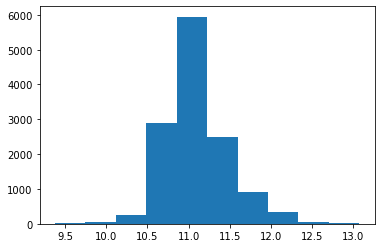

In [180]:
plt.hist(np.log10(Mhalo_bulgy_disks))

(array([8.610e+03, 4.046e+03, 2.080e+02, 6.300e+01, 2.000e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  3.58669013,  33.17901716,  62.7713442 ,  92.36367123,
        121.95599826, 151.54832529, 181.14065233, 210.73297936,
        240.32530639, 269.91763342, 299.50996046]),
 <BarContainer object of 10 artists>)

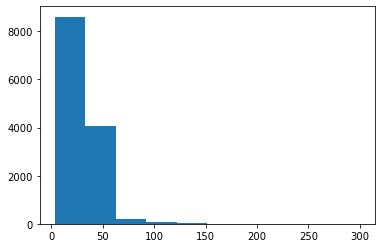

In [181]:
plt.hist(df_bulgy_disks['GalpropNormHalfRadius'])

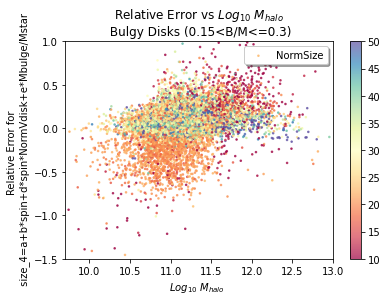

In [182]:
plt.scatter(np.log10(Mhalo_bulgy_disks), relative_error_4_bulgy,
            c = df_bulgy_disks['GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'NormSize', vmin=10.0, vmax=50)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([9.7,13, -1.5,1.0])
plt.title('Relative Error vs $ Log_{10} $ $M_{halo}$ \n Bulgy Disks (0.15<B/M<=0.3)')
plt.ylabel('Relative Error for \n size_4=a+b*spin+d*spin*NormVdisk+e*Mbulge/Mstar')
plt.xlabel('$ Log_{10} $ $M_{halo}$  ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('RelativeError4_vs_Mhalo_bulgy_disks_sizecolor_scaleconstrained.jpeg', dpi=500)
plt.show()
# $\log_{10} $  Galaxy Mass $[M_\odot] $

### case 5: Using size_5 = a + b*spin + d*spin*vdisk + f*ln(1-Mbulge/Mstar) from Disks on Bulgy Disks

In [183]:
size_5_bulgy = spin_vdisk_log_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_5)

In [184]:
r2_score_size_funcsize_5_bulgy=r2_score(Size_bulgy, size_5_bulgy)

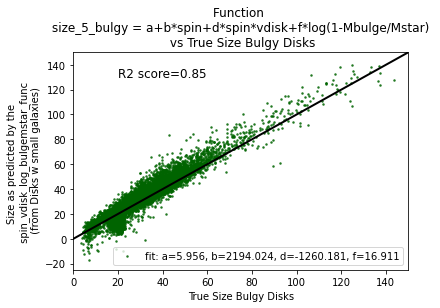

In [185]:
plt.scatter(Size_bulgy, size_5_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, f=%5.3f' % tuple(popt_5))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_5_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function \n size_5_bulgy = a+b*spin+d*spin*vdisk+f*log(1-Mbulge/Mstar) \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n spin_vdisk_log_bulgemstar_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_5_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 6: Using size_6 = spin/vdisk^2 + g*Mbulge/Mstar equation (the function predicted by SR + Mbulge/Mstar term) from Disks on  Bulgy Disks

In [186]:
size_6_bulgy = spin_over_vdisk_squared_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_6)

In [187]:
r2_score_size_funcsize_6_bulgy=r2_score(Size_bulgy, size_6_bulgy)

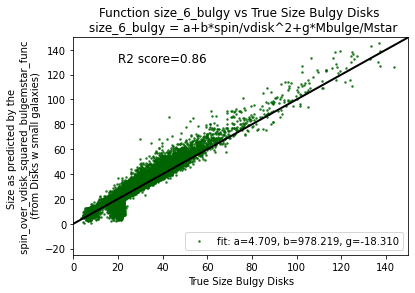

In [188]:
plt.scatter(Size_bulgy, size_6_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, g=%5.3f' % tuple(popt_6))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_6_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_6_bulgy vs True Size Bulgy Disks \n size_6_bulgy = a+b*spin/vdisk^2+g*Mbulge/Mstar')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_bulgemstar_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_6_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 7: Using size_7 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) equation (the function predicted by SR + log(1-Mbulge/Mstar) term from Disks on Bulgy Disks

In [189]:
size_7_bulgy = spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_7)

In [190]:
r2_score_size_funcsize_7_bulgy=r2_score(Size_bulgy, size_7_bulgy)

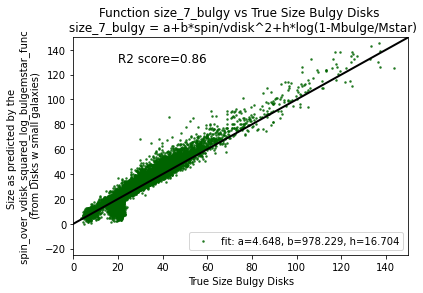

In [191]:
plt.scatter(Size_bulgy, size_7_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f' % tuple(popt_7))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_7_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_7_bulgy vs True Size Bulgy Disks \n size_7_bulgy = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_7_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 8: Using size_8 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + j*MHI function from Disks on Bulgy Disks

In [192]:
MHI_bulgy = np.array (df_bulgy_disks.loc[:, 'GalpropNormMHI'])

spin_vdisk_bmstar_MHI_bulgy = np. array([HalopropSpin_bulgy, GalpropNormVdisk_bulgy, BulgeMstar_bulgy, MHI_bulgy])

In [193]:
size_8_bulgy = spin_over_vdisk_squared_log_bulgemstar_MHI_func(spin_vdisk_bmstar_MHI_bulgy, *popt_8)

r2_score_size_funcsize_8_bulgy=r2_score(Size_bulgy, size_8_bulgy)

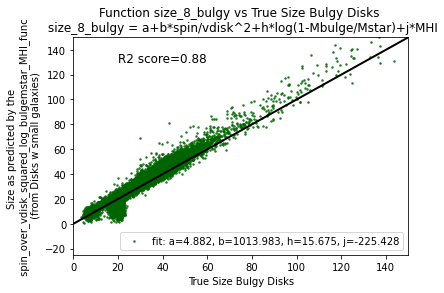

In [194]:
plt.scatter(Size_bulgy, size_8_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_8))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_8_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_8_bulgy vs True Size Bulgy Disks \n size_8_bulgy = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)+j*MHI')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar_MHI_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_8_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 9: size_9 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + spin*MHI funtion from Disks on Bulgy Disks

In [195]:
size_9_bulgy = MHI_spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_MHI_bulgy, *popt_9)

r2_score_size_funcsize_9_bulgy=r2_score(Size_bulgy, size_9_bulgy)

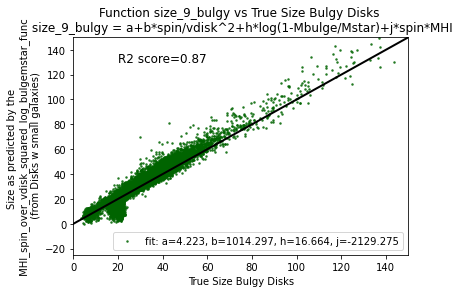

In [196]:
plt.scatter(Size_bulgy, size_9_bulgy, marker='.', s=10, alpha=0.7, c='darkgreen',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_9))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_9_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_9_bulgy vs True Size Bulgy Disks \n size_9_bulgy = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)+j*spin*MHI')
plt.ylabel('Size as predicted by the \n MHI_spin_over_vdisk_squared_log_bulgemstar_func \n (from Disks w small galaxies)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_9_funcwsmalldiskgals.jpeg', dpi=500)
plt.show()

### case 14: " size_14 = a+b*spin/vdisk^2 where spin=spin_min " function from Disks on Bulgy Disks

In [197]:
size_14_bulgy = spin_vdisk2_wsmallgals_4_func(spin_vdisk_bulgy, *popt_14)

In [198]:
r2_score_size_funcsize_14_bulgy=r2_score(Size_bulgy, size_14_bulgy)
r2_score_size_funcsize_14_bulgy

0.7987425755896547

In [199]:
df_spin_size_14_bulgy = df_bulgy_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_14_bulgy["Predicted"] = size_14_bulgy
zz_14_bulgy = df_spin_size_14_bulgy[df_spin_size_14_bulgy['HalopropSpin']<=0.021]
actual_size_14_bulgy = zz_14_bulgy['GalpropNormHalfRadius']
predicted_size_14_bulgy = zz_14_bulgy['Predicted']
r2_score(actual_size_14_bulgy, predicted_size_14_bulgy)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/2529810049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_14_bulgy["Predicted"] = size_14_bulgy


0.6155183497063642

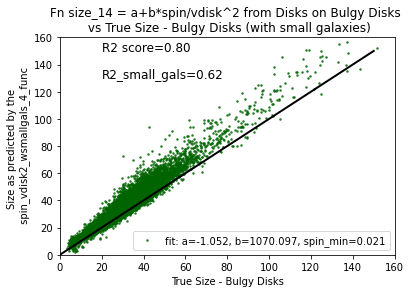

In [214]:
plt.scatter(Size_bulgy, size_14_bulgy, marker='.', s=10, alpha=0.7, c = 'darkgreen',
        label='fit: a=%5.3f, b=%5.3f, spin_min=%5.3f' % tuple(popt_14))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,160, 0.0,160])
plt.text(20, 150, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_14_bulgy), size=12)
plt.text(20, 130, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_14_bulgy, predicted_size_14_bulgy)), size=12)
plt.title('Fn size_14 = a+b*spin/vdisk^2 from Disks on Bulgy Disks \n vs True Size - Bulgy Disks (with small galaxies)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_4_func')
plt.xlabel('True Size - Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_FunctionSize_14_wsmallgals.jpeg', dpi=500)
plt.show()

### case 15: " size_15 = a+b*spin/vdisk^2 where spin=spin_min " function optimized on Bulgy Disks


In [229]:
# I'm choosing p0 values from the SR function from Bulgy Disks (size_3a) and the spin-size plot for Bulgy Disks

popt_15_bulgy, pcov_15_bulgy = curve_fit(spin_vdisk2_wsmallgals_4_func, spin_vdisk_bulgy, Size_bulgy, p0=[0.5, 900, 0.002])

size_15_bulgy = spin_vdisk2_wsmallgals_4_func(spin_vdisk_bulgy, *popt_15_bulgy)

In [230]:
popt_15_bulgy

array([1.27580032e+00, 8.75499000e+02, 2.06116878e-02])

In [231]:
r2_score_size_funcsize_15_bulgy=r2_score(Size_bulgy, size_15_bulgy)
r2_score_size_funcsize_15_bulgy

0.9354892813400484

In [232]:
df_spin_size_15_bulgy = df_bulgy_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_15_bulgy["Predicted"] = size_15_bulgy
zz_15_bulgy = df_spin_size_15_bulgy[df_spin_size_15_bulgy['HalopropSpin']<=0.021]
actual_size_15_bulgy = zz_15_bulgy['GalpropNormHalfRadius']
predicted_size_15_bulgy = zz_15_bulgy['Predicted']
r2_score(actual_size_15_bulgy, predicted_size_15_bulgy)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/792439720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_15_bulgy["Predicted"] = size_15_bulgy


0.7607699398117224

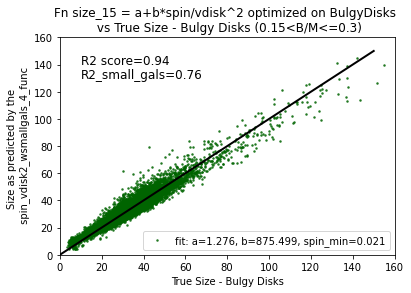

In [292]:
plt.scatter(Size_bulgy, size_15_bulgy, marker='.', s=10, alpha=0.7, c = 'darkgreen',
        label='fit: a=%5.3f, b=%5.3f, spin_min=%5.3f' % tuple(popt_15_bulgy))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,160, 0.0,160])
plt.text(10, 140, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_15_bulgy), size=12)
plt.text(10, 130, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_15_bulgy, predicted_size_15_bulgy)), size=12)
plt.title('Fn size_15 = a+b*spin/vdisk^2 optimized on BulgyDisks \n vs True Size - Bulgy Disks (0.15<B/M<=0.3)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_4_func')
plt.xlabel('True Size - Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =30> </a> <br> 3. Bulgier Disk Galaxies: 0.3< B/Mstar <=0.5

In [217]:
df_bulgier_disks = pd.read_csv('Bulgier Disks Dataset_as defined in notebook v13')

In [218]:
df_bulgier_disks.shape

(4302, 33)

In [219]:
X_bulgier_disks = df_bulgier_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_bulgier_disks = df_bulgier_disks.loc[:,'GalpropNormHalfRadius']

In [220]:
# choose the 7 most important features from analysis above to be used for physical modelling

X_bulgier_disks_imp = df_bulgier_disks.loc[:, ['HalopropSpin', 'GalpropNormSigmaBulge', 
                                                'GalpropNormMHI', 'GalpropNormMbulge',
                                                'GalpropNormMstar', 'GalpropNormVdisk',
                                                'GalpropZcold']]


y_bulgier_disks_imp = df_bulgier_disks.loc[:, 'GalpropNormHalfRadius']

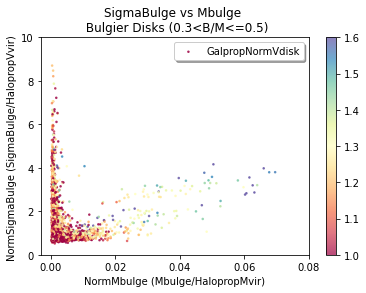

In [221]:
plt.scatter(df_bulgier_disks.loc[:,'GalpropNormMbulge'], df_bulgier_disks.loc[:, 'GalpropNormSigmaBulge'],
            c = df_bulgier_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-0.003,0.08, 0.0,10])
plt.title('SigmaBulge vs Mbulge \n Bulgier Disks (0.3<B/M<=0.5)')
plt.xlabel('NormMbulge (Mbulge/HalopropMvir)')
plt.ylabel('NormSigmaBulge (SigmaBulge/HalopropVvir) ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('BulgierDisks_SigmaBulge_vs_Mbulge_vdiskcolor.jpeg', dpi=500)
plt.show() 

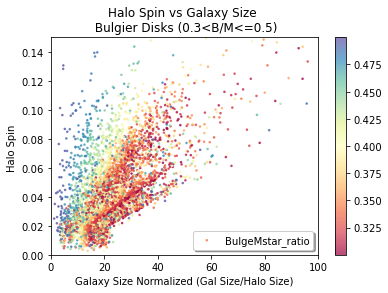

In [302]:
plt.scatter(df_bulgier_disks.loc[:,'GalpropNormHalfRadius'], df_bulgier_disks.loc[:, 'HalopropSpin'],
            c = df_bulgier_disks['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'BulgeMstar_ratio') #, vmin=1.0, vmax=1.4)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.15])
plt.title('Halo Spin vs Galaxy Size \n Bulgier Disks (0.3<B/M<=0.5)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('BulgierDisks_Spin_vs_Size_vdiskcolor.jpeg', dpi=500)
plt.show()

In [223]:
df_bulgier_small = df_bulgier_disks[df_bulgier_disks['HalopropSpin']<=0.021]

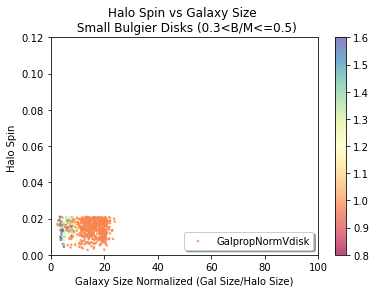

In [224]:
plt.scatter(df_bulgier_small.loc[:,'GalpropNormHalfRadius'], df_bulgier_small.loc[:, 'HalopropSpin'],
            c = df_bulgier_small['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.8, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Small Bulgier Disks (0.3<B/M<=0.5)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('BulgierDisks_Spin_vs_Size_vdiskcolor.jpeg', dpi=500)
plt.show()

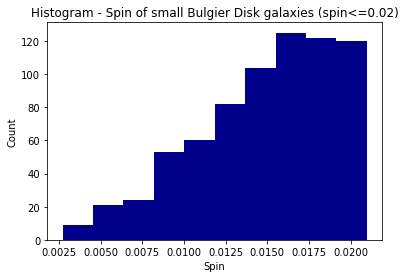

In [225]:
plt.hist(df_bulgier_small['HalopropSpin'], color='darkblue')
plt.title('Histogram - Spin of small Bulgier Disk galaxies (spin<=0.02)')
plt.ylabel('Count')
plt.xlabel('Spin')
# plt.savefig('BulgierDisks Histogram of Spin of small galaxies.jpeg', dpi=500)
plt.show()

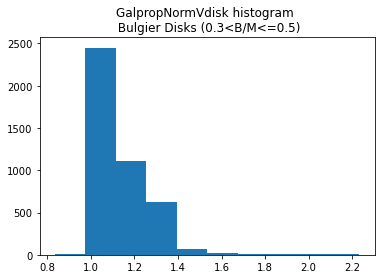

In [226]:
plt.hist(df_bulgier_disks['GalpropNormVdisk'])
plt.title('GalpropNormVdisk histogram \n Bulgier Disks (0.3<B/M<=0.5)')
# plt.savefig('GalpropNormVdisk_bulgier_disks_histogram', dpi=500)
plt.show()

#### Define the 2,M array for Bulgier Disks to use on curve_fit

In [227]:
Size_bulgier = np.array(df_bulgier_disks['GalpropNormHalfRadius'])

HalopropSpin_bulgier = df_bulgier_disks.loc[:, 'HalopropSpin']

HalopropSpin_bulgier = np.array(HalopropSpin_bulgier)

GalpropNormVdisk_bulgier = df_bulgier_disks.loc[:, 'GalpropNormVdisk']

GalpropNormVdisk_bulgier = np.array(GalpropNormVdisk_bulgier)

GalpropNormVdisk_bulgier

array([0.99308364, 1.39366458, 0.99308364, ..., 0.99308466, 1.3255352 ,
       0.99308341])

In [310]:
spin_vdisk_bulgier = [HalopropSpin_bulgier, GalpropNormVdisk_bulgier]
spin_vdisk_bulgier = np.array (spin_vdisk_bulgier) # convert list into array

In [305]:
type(spin_vdisk)

numpy.ndarray

### case 15: " size_15 = a+b*spin/vdisk^2 where spin=spin_min " function optimized on Bulgier Disks

In [235]:
# I'm guessing p0 values and looking at the spin-size plot for Bulgier Disks

popt_15_bulgier, pcov_15_bulgier = curve_fit(spin_vdisk2_wsmallgals_4_func, spin_vdisk_bulgier, Size_bulgier, p0=[0.5, 700, 0.002])

size_15_bulgier = spin_vdisk2_wsmallgals_4_func(spin_vdisk_bulgier, *popt_15_bulgier)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/scipy-1.8.0rc2-py3.9-macosx-11.1-arm64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [236]:
popt_15_bulgier

array([7.50990648e+00, 4.37402261e+02, 2.00000000e-03])

In [237]:
r2_score_size_funcsize_15_bulgier=r2_score(Size_bulgier, size_15_bulgier)
r2_score_size_funcsize_15_bulgier

0.49968042292185544

In [238]:
df_spin_size_15_bulgier = df_bulgier_disks[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_15_bulgier["Predicted"] = size_15_bulgier
zz_15_bulgier = df_spin_size_15_bulgier[df_spin_size_15_bulgier['HalopropSpin']<=0.021]
actual_size_15_bulgier = zz_15_bulgier['GalpropNormHalfRadius']
predicted_size_15_bulgier = zz_15_bulgier['Predicted']
r2_score(actual_size_15_bulgier, predicted_size_15_bulgier)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/3500282499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_15_bulgier["Predicted"] = size_15_bulgier


0.08081510566689976

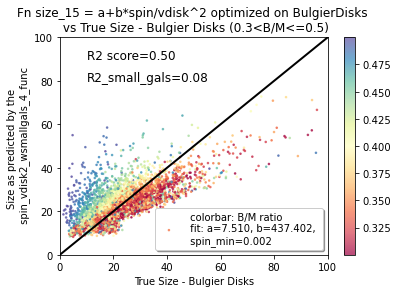

In [290]:
plt.scatter(Size_bulgier, size_15_bulgier, marker='.', s=10, alpha=0.7, 
            c  = df_bulgier_disks['BulgeMstar_ratio'],  
            cmap='Spectral',
            label=' colorbar: B/M ratio \n fit: a=%5.3f, b=%5.3f, \n spin_min=%5.3f' % tuple(popt_15_bulgier))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.text(10, 90, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_15_bulgier), size=12)
plt.text(10, 80, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_15_bulgier, predicted_size_15_bulgier)), size=12)
plt.title('Fn size_15 = a+b*spin/vdisk^2 optimized on BulgierDisks \n vs True Size - Bulgier Disks (0.3<B/M<=0.5)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_4_func')
plt.xlabel('True Size - Bulgier Disks')
plt.legend(loc = 'lower right', shadow=True)
plt.colorbar()
# plt.savefig('BulgierDisks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =30> </a> <br> 4. Elliptical Galaxies: B/Mstar > 0.5

In [258]:
df_ellipticals = pd.read_csv('Ellipticals Dataset_as defined in notebook v13')

In [259]:
df_ellipticals.shape

(2422, 33)

In [260]:
X_ellipticals = df_ellipticals.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_ellipticals = df_ellipticals.loc[:,'GalpropNormHalfRadius']

In [261]:
# choose the 7 most important features from analysis above to be used for physical modelling

X_ellipticals_imp = df_ellipticals.loc[:, ['GalpropNormSigmaBulge', 'GalpropNormMstar',
                                                   'GalpropNormMstar_merge', 'HalopropSpin',
                                                   'HalopropC_nfw', 'GalpropNormMbulge',
                                                   'HalopropMetal_ejected'
                                                  ]]


y_ellipticals_imp = df_ellipticals.loc[:, 'GalpropNormHalfRadius']

### case 15: " size_15 = a+b*spin/vdisk^2 where spin=spin_min " function optimized on Ellipticals


In [262]:
Size_ellipticals = np.array(df_ellipticals['GalpropNormHalfRadius'])

HalopropSpin_ellipticals = df_ellipticals.loc[:, 'HalopropSpin']

HalopropSpin_ellipticals = np.array(HalopropSpin_ellipticals)

GalpropNormVdisk_ellipticals = df_ellipticals.loc[:, 'GalpropNormVdisk']

GalpropNormVdisk_ellipticals = np.array(GalpropNormVdisk_ellipticals)

spin_vdisk_ellipticals = [HalopropSpin_ellipticals, GalpropNormVdisk_ellipticals]
spin_vdisk_ellipticals = np.array (spin_vdisk_ellipticals) # convert list into array

In [284]:
# I'm guessing p0 values and looking at the spin-size plot for Bulgier Disks

popt_15_ellipticals, pcov_15_ellipticals = curve_fit(spin_vdisk2_wsmallgals_4_func, spin_vdisk_ellipticals, Size_ellipticals, p0=[0.5, 700, 0.002])

size_15_ellipticals = spin_vdisk2_wsmallgals_4_func(spin_vdisk_ellipticals, *popt_15_ellipticals)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/scipy-1.8.0rc2-py3.9-macosx-11.1-arm64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [285]:
popt_15_ellipticals

array([ 8.19884526, 37.63975717, -0.04648667])

In [286]:
r2_score_size_funcsize_15_ellipticals=r2_score(Size_ellipticals, size_15_ellipticals)
r2_score_size_funcsize_15_ellipticals

0.008584979221452516

In [287]:
df_spin_size_15_ellipticals = df_ellipticals[['GalpropNormHalfRadius', 'HalopropSpin']]
df_spin_size_15_ellipticals["Predicted"] = size_15_ellipticals
zz_15_ellipticals = df_spin_size_15_ellipticals[df_spin_size_15_ellipticals['HalopropSpin']<=0.021]
actual_size_15_ellipticals = zz_15_ellipticals['GalpropNormHalfRadius']
predicted_size_15_ellipticals = zz_15_ellipticals['Predicted']
r2_score(actual_size_15_ellipticals, predicted_size_15_ellipticals)

/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_93671/627437500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spin_size_15_ellipticals["Predicted"] = size_15_ellipticals


0.009597618557184995

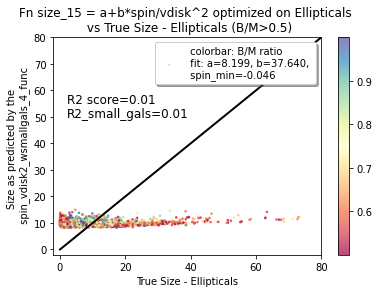

In [300]:
plt.scatter(Size_ellipticals, size_15_ellipticals, marker='.', s=10, alpha=0.7, 
            c  = df_ellipticals['BulgeMstar_ratio'],  
            cmap='Spectral',
            label=' colorbar: B/M ratio \n fit: a=%5.3f, b=%5.3f, \n spin_min=%5.3f' % tuple(popt_15_ellipticals))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-2.0,80, -2.0,80])
plt.text(2, 55, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_15_ellipticals), size=12)
plt.text(2, 50, 'R2_small_gals=' + '{:.2f}'.format(r2_score(actual_size_15_ellipticals, predicted_size_15_ellipticals)), size=12)
plt.title('Fn size_15 = a+b*spin/vdisk^2 optimized on Ellipticals \n vs True Size - Ellipticals (B/M>0.5)')
plt.ylabel('Size as predicted by the \n spin_vdisk2_wsmallgals_4_func')
plt.xlabel('True Size - Ellipticals')
plt.legend(loc = 'upper right', shadow=True)
plt.colorbar()
# plt.savefig('Ellipticals_TrueSize_vs_FunctionSize_15_wsmallgals_biggerscale.jpeg', dpi=500)
plt.show()

### properties of ellipticals

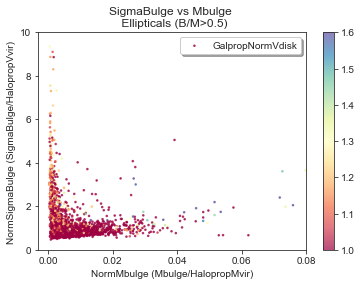

In [340]:
plt.scatter(df_ellipticals.loc[:,'GalpropNormMbulge'], df_ellipticals.loc[:, 'GalpropNormSigmaBulge'],
            c = df_ellipticals['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-0.003,0.08, 0.0,10])
plt.title('SigmaBulge vs Mbulge \n Ellipticals (B/M>0.5)')
plt.xlabel('NormMbulge (Mbulge/HalopropMvir)')
plt.ylabel('NormSigmaBulge (SigmaBulge/HalopropVvir) ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('Ellipticals_SigmaBulge_vs_Mbulge_vdiskcolor.jpeg', dpi=500)
plt.show() 

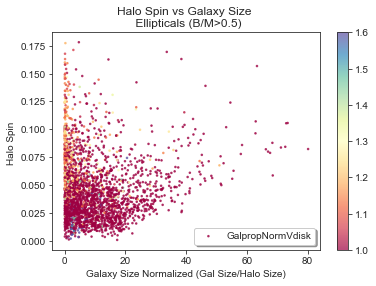

In [339]:
plt.scatter(df_ellipticals.loc[:,'GalpropNormHalfRadius'], df_ellipticals.loc[:, 'HalopropSpin'],
            c = df_ellipticals['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.15])
plt.title('Halo Spin vs Galaxy Size \n Ellipticals (B/M>0.5)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Ellipticals_Spin_vs_Size_vdiskcolor.jpeg', dpi=500)
plt.show()

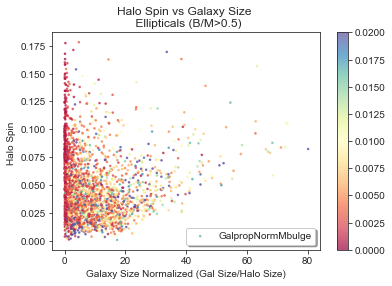

In [341]:
plt.scatter(df_ellipticals.loc[:,'GalpropNormHalfRadius'], df_ellipticals.loc[:, 'HalopropSpin'],
            c = df_ellipticals['GalpropNormMbulge'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormMbulge', vmin=0.0, vmax=0.02)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.15])
plt.title('Halo Spin vs Galaxy Size \n Ellipticals (B/M>0.5)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Ellipticals_Spin_vs_Size_mbulgecolor.jpeg', dpi=500)
plt.show()

In [308]:
df_ellipticals['GalpropNormMbulge'].max()

9.356539536790455

In [364]:
# 1,178 (out of 2,422 ellipticals) galaxies have NormMbulge=0
(np.round(df_ellipticals['GalpropNormMbulge'], 2)==0.0).sum()

1178

In [327]:

np.count_nonzero(df_ellipticals['GalpropNormMbulge'])

2422

In [306]:
df_ellipticals['GalpropNormMbulge'].values

array([0.01612538, 0.01620573, 0.00938321, ..., 0.00335418, 0.00143169,
       0.0007103 ])

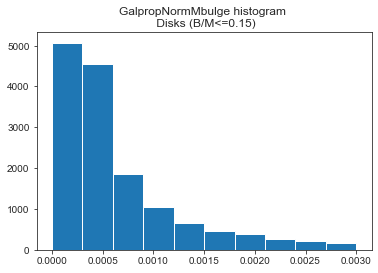

In [354]:

plt.hist(df_disks['GalpropNormMbulge'], range=(0.0, 0.003))
plt.title('GalpropNormMbulge histogram \n Disks (B/M<=0.15)')
# plt.savefig('GalpropNormMbulge_ellipticals_histogram', dpi=500)
plt.show()

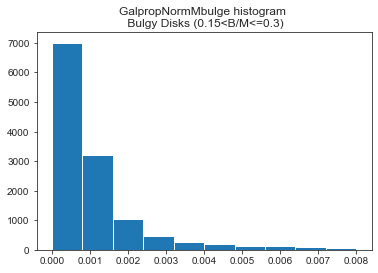

In [358]:
plt.hist(df_bulgy_disks['GalpropNormMbulge'], range=(0.0, 0.008))
plt.title('GalpropNormMbulge histogram \n Bulgy Disks (0.15<B/M<=0.3)')
# plt.savefig('GalpropNormMbulge_ellipticals_histogram', dpi=500)
plt.show()

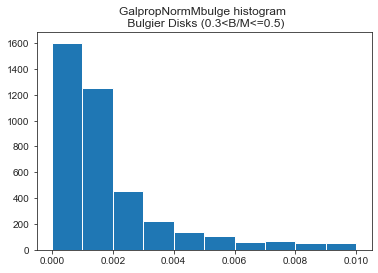

In [361]:
plt.hist(df_bulgier_disks['GalpropNormMbulge'], range=(0.0, 0.01))
plt.title('GalpropNormMbulge histogram \n Bulgier Disks (0.3<B/M<=0.5)')
# plt.savefig('GalpropNormMbulge_ellipticals_histogram', dpi=500)
plt.show()

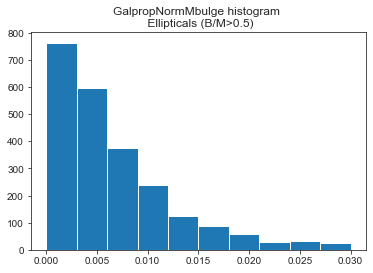

In [347]:

plt.hist(df_ellipticals['GalpropNormMbulge'], range=(0.0, 0.03))
plt.title('GalpropNormMbulge histogram \n Ellipticals (B/M>0.5)')
# plt.savefig('GalpropNormMbulge_ellipticals_histogram', dpi=500)
plt.show()

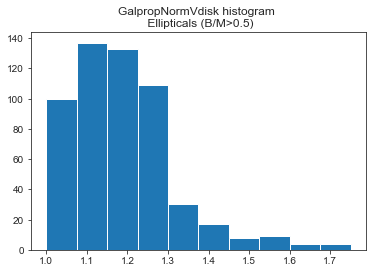

In [368]:

plt.hist(df_ellipticals['GalpropNormVdisk'], range=(1.0, 1.75))
plt.title('GalpropNormVdisk histogram \n Ellipticals (B/M>0.5)')
# plt.savefig('GalpropNormMbulge_ellipticals_histogram', dpi=500)
plt.show()

In [328]:
df_ellipticals_small = df_ellipticals[df_ellipticals['HalopropSpin']<=0.021]

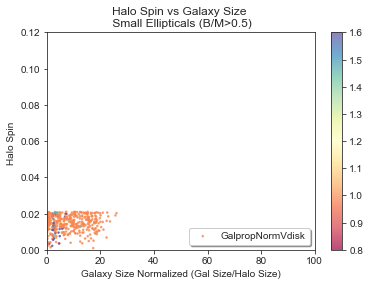

In [337]:
plt.scatter(df_ellipticals_small.loc[:,'GalpropNormHalfRadius'], df_ellipticals_small.loc[:, 'HalopropSpin'],
            c = df_ellipticals_small['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.8, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Small Ellipticals (B/M>0.5)')
plt.xlabel('Galaxy Size Normalized (Gal Size/Halo Size)')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Ellipticals_Spin_vs_Size_vdiskcolor.jpeg', dpi=500)
plt.show()